# Car Price Prediction Model (Built During Covid Pandemic)

In [1]:
import numpy as np 
import pandas as pd 
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import StackingRegressor
from sklearn.base import clone
from scipy import stats
from itertools import combinations
from sklearn.model_selection import GridSearchCV
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


* [Setup](#setup)
* [Scraping Data](#scraping)
* [Data Pre-Processing](#preprocessing)
* [Merge Tables](#merge)
* [EDA](#eda)
   * [Target](#target)
   * [Numeric Features](#number)
   * [Categorical Features](#category)
* [Feature Engineering](#engineering)
* [Label Encoding](#encoding)
* [CatBoost Model](#catmodel)
* [CatBoost Model+CV](#catmodelcv)
* [RandomForest Model](#randforest)
* [Gradinet Boost Model](#grad)
* [XGBoost Model](#xgboost)
* [LightGB Model](#lightgb)
* [Bagging Model](#bagging)
* [AdaBoost Model](#adaboost)
* [Stacking Model](#stacking)
* [Voting Model](#voting)
   

In [2]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5


In [3]:

#!pip freeze > requirements.txt

In [4]:

# fixed seed value, so that your train-test splits are always deterministic
RANDOM_SEED = 42

In [5]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# Setup <a id="setup"></a>

In [6]:
VERSION    = 16
DIR_TRAIN  = '../input/parsing-all-moscow-auto-ru-09-09-2020/' 
DIR_TEST   = '../input/sf-dst-car-price-prediction/'
VAL_SIZE   = 0.20   
DIR_Collected = '../input/collected-train-data/'
DIR_TRAINING_DATA = '../input/training-data/'
DIR_TEST_ADDITIONAL = '../input/test-additional-parameters/'

# Data

In [7]:
train = pd.read_csv(DIR_TRAIN+'all_auto_ru_09_09_2020.csv') 
training = pd.read_csv(DIR_TRAINING_DATA + 'training_data_with_specs.csv')
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')
test_additional_specs = pd.read_csv(DIR_TEST_ADDITIONAL+'test_additional_parameters.csv')

In [8]:

# finding_outliers is function to analyze categorical features


def finding_outliers(table, column, log='no', dataframe='no'):
    if log == 'no':
        perc25 = table[column].quantile(0.25)
        perc75 = table[column].quantile(0.75)

        low_bound = perc25 - 1.5 * (perc75 - perc25)
        top_bound = perc75 + 1.5 * (perc75 - perc25)

        if dataframe == 'yes':
            return table[(table[column] < top_bound) & (table[column] > low_bound)]

        numb_of_outliers = len(table) - len(table[(table[column] < top_bound) &
                                                  (table[column] > low_bound)])

    elif log == 'yes':
        perc25 = np.log(table[column]).quantile(0.25)
        perc75 = np.log(table[column]).quantile(0.75)

        low_bound = perc25 - 1.5 * (perc75 - perc25)
        top_bound = perc75 + 1.5 * (perc75 - perc25)

        numb_of_outliers = len(table) - len(table[(np.log(table[column]) < top_bound) &
                                                  (np.log(table[column]) > low_bound)])

    return numb_of_outliers


def numerical_columns_anaylysis(table, column, bins, log='no'):
    if column != 'price':

        if log == 'no':
            display(table[column].describe())
            display(table[column].plot(kind='hist', bins=bins))
            
            fig, axes = plt.subplots(2, figsize=(16, 12))
            sns.distplot(table[column], ax=axes[0])
            sns.boxplot(table[column], ax=axes[1], color='g', meanline=True)
            plt.title(column)
            plt.show()
        elif log == 'yes':
            display(np.log(table[column]).describe())

            display(np.log(table[column]).plot(kind='hist', bins=bins))
            fig, axes = plt.subplots(2, figsize=(16, 12))
            
            sns.distplot(np.log(table[column]), ax=axes[0])
            sns.boxplot(np.log(table[column]),
                        ax=axes[1], color='g', meanline=True)
            plt.title(column)
            plt.show()

    else:
        if log == 'no':
            display(table[table.sample_kaggle == 1][column].describe())
            display(table[table.sample_kaggle == 1]
                    [column].plot(kind='hist', bins=bins))
            
            plt.xlim(0, 7000000)
            fig, axes = plt.subplots(2, figsize=(16, 12))

            sns.distplot(table[table.sample_kaggle == 1]
                         [column], ax=axes[0]).set(xlim=(0, 20000000))
            sns.boxplot(table[table.sample_kaggle == 1][column],
                        ax=axes[1], color='g', meanline=True)
            plt.title(column)
            plt.show()
        elif log == 'yes':
            display(np.log(table[data.sample_kaggle == 1][column]).describe())
            display(np.log(table[table.sample_kaggle == 1]
                           [column]).plot(kind='hist', bins=bins))
            
            fig, axes = plt.subplots(2, figsize=(16, 12))
            sns.distplot(
                np.log(table[table.sample_kaggle == 1][column]), ax=axes[0])
            sns.boxplot(np.log(table[table.sample_kaggle == 1]
                               [column]), ax=axes[1], color='g', meanline=True)
            plt.title(column)
            plt.show()


def category_over_numeric_features(category_feature, stop):
    numeric_clmns = ['enginePower', 'mileage', 'reaching_100', 'modelDate',
                     'productionDate', 'numb_of_doors', 'number_of_gears', 'price']

    lim = data[category_feature].value_counts().index[:stop]

    for clmn in numeric_clmns:
        boarder = 4 * data[clmn].quantile(0.75)
        plt.figure(figsize=(7, 4))
        plt.xticks(rotation=45)
        if clmn == 'productionDate' or clmn == 'modelDate':
            boarder = data[clmn].quantile(0.75) + 25
            plt.ylim(1925, boarder)
        else:
            boarder = 4 * data[clmn].quantile(0.75)
            plt.ylim(0, boarder)
        if clmn == 'price':
            sns.boxplot(x=category_feature, y=clmn,
                        data=data[data.sample_kaggle == 1][data[category_feature].isin(lim)], palette='pastel')
        else:
            sns.boxplot(x=category_feature, y=clmn,
                        data=data[data[category_feature].isin(lim)], palette='pastel')


def category_ratio(table, column, stop):

    display(table[column].value_counts())
    table[column].value_counts()[:stop].plot.pie(y='index', figsize=(9, 9),
                                                 title=column, autopct='%1.1f%%', startangle=50.)

    fig, axes = plt.subplots(figsize=(9, 5))

    sns.barplot(x=table[column].astype(str).value_counts().index[:stop],
                y=table[column].value_counts(normalize=True).values[:stop], palette='magma')
    plt.title(f'Major categories for "{column}"', size=1)
    plt.ylabel('Ratio')

    plt.xticks(rotation=45)
    plt.subplots_adjust(wspace=0.2)


def get_stat_dif(column, table, numeric_featurs):
    if column == 'price':
        table = table[table.sample_kaggle == 1]

    cols = table.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for feature in numeric_featurs:

        for comb in combinations_all:
            if stats.ttest_ind(table.loc[table.loc[:, column] == comb[0], feature],
                               table.loc[table.loc[:, column]
                                         == comb[1], feature]
                               ).pvalue <= 0.05 / len(combinations_all):  
                print('Noticable statisctical significance found for ',
                      column, '  in relationship to  ', feature)
                break

# Scraping Data Collection <a id="scraping"></a>

<img src="https://www.octoparse.com/media/7529/web-scraping-introduction.jpg?width=640&height=480">



In [9]:

# This code was used to collect cars post ad links

'''
import requests
from bs4 import BeautifulSoup
import csv
import re
from concurrent.futures import ThreadPoolExecutor
import asyncio


url = 'https://auto.ru/?utm_campaign=404_new_version_logo&utm_source=404'
links = []
soup = BeautifulSoup(requests.get(
    url, headers={'User-Agent': 'Mozilla/5.0'}).text, 'html.parser')

model_links = soup.find_all('a', class_="IndexMarks__item")

print(len(model_links))
for link in model_links:
    model_page = link['href']
    model_page = model_page.replace('all', 'used')
    print(model_page)
    links.append(model_page)


extended_links = []


def model_page_offers(model_page):
    mod_page_offers = model_page
    offers_soup = BeautifulSoup(requests.get(mod_page_offers, headers={
                                'User-Agent': 'Mozilla/5.0'}).text, 'html.parser')
    number_of_offers = offers_soup.find(
        'span', class_='ButtonWithLoader__content').text
    strring = ''

    for char in number_of_offers:
        if char in '0123456789':
            strring += char

    number = int(strring)

    if number <= 5000:
        return [model_page]

    elif number <= 10000:
        return [model_page + '?year_to=2010', model_page + '?year_from=2011']

    elif number <= 20000:
        return [model_page + '?year_to=2002', model_page + '?year_from=2003&year_to=2007', 
                model_page + '?year_from=2008&year_to=2012', model_page + '?year_from=2013&year_to=2016', 
                model_page + '?year_from=2017']

    else:
        return [model_page + '?year_to=1998', model_page + '?year_from=1999&year_to=2002',
                model_page + '?year_from=2003&year_to=2006', model_page +
                '?year_from=2007&year_to=2010',
                model_page + '?year_from=2011&year_to=2014', model_page + '?year_from=2015&year_to=2018', 
                model_page + '?year_from=2019']


for page in links:

    extended_links.extend(model_page_offers(page))
    
'''

'\nimport requests\nfrom bs4 import BeautifulSoup\nimport csv\nimport re\nfrom concurrent.futures import ThreadPoolExecutor\nimport asyncio\n\n\nurl = \'https://auto.ru/?utm_campaign=404_new_version_logo&utm_source=404\'\nlinks = []\nsoup = BeautifulSoup(requests.get(\n    url, headers={\'User-Agent\': \'Mozilla/5.0\'}).text, \'html.parser\')\n\nmodel_links = soup.find_all(\'a\', class_="IndexMarks__item")\n\nprint(len(model_links))\nfor link in model_links:\n    model_page = link[\'href\']\n    model_page = model_page.replace(\'all\', \'used\')\n    print(model_page)\n    links.append(model_page)\n\n\nextended_links = []\n\n\ndef model_page_offers(model_page):\n    mod_page_offers = model_page\n    offers_soup = BeautifulSoup(requests.get(mod_page_offers, headers={\n                                \'User-Agent\': \'Mozilla/5.0\'}).text, \'html.parser\')\n    number_of_offers = offers_soup.find(\n        \'span\', class_=\'ButtonWithLoader__content\').text\n    strring = \'\'\n\n    fo

In [10]:


# This code lets to collect information much faster. I ran it in my pycharm IDE

'''
async def collect_info_async(pages, function):
    res = []
    with ThreadPoolExecutor(max_workers=25) as executor:
        with requests.Session() as session:
            loop = asyncio.get_event_loop()
            tasks = [
                loop.run_in_executor(executor, function, *(url, session)) for url in pages
            ]

            for response in await asyncio.gather(*tasks):
                res.append(response)
                
                
'''

'\nasync def collect_info_async(pages, function):\n    res = []\n    with ThreadPoolExecutor(max_workers=25) as executor:\n        with requests.Session() as session:\n            loop = asyncio.get_event_loop()\n            tasks = [\n                loop.run_in_executor(executor, function, *(url, session)) for url in pages\n            ]\n\n            for response in await asyncio.gather(*tasks):\n                res.append(response)\n                \n                \n'

In [11]:

# This code collects links for specific car ads and then it saves them

'''
prod_links = open('product_links.csv', 'w', encoding="utf-8")
csv_writer = csv.writer(prod_links)
csv_writer.writerow(['url'])

def collect_product_links(posting_page, session):
    product_links_soup = BeautifulSoup(session.get(
        posting_page, headers={'User-Agent': 'Mozilla/5.0'}).text, 'html.parser')
    prd_links = product_links_soup.find_all(
        'a', class_='Link ListingItemTitle__link')
    
    for url in prd_links:
        product_links.append(url['href'])
        prd_link = url['href']
        csv_writer.writerow([prd_link])

    print(len(product_links))
    while product_links_soup.find('link', rel="next"):
        nxt_page = product_links_soup.find('link', rel="next")['href']
        product_links_soup = BeautifulSoup(session.get(
            nxt_page, headers={'User-Agent': 'Mozilla/5.0'}).text, 'html.parser')
        prd_links = product_links_soup.find_all(
            'a', class_='Link ListingItemTitle__link')
        for url in prd_links:
            product_links.append(url['href'])
            prd_link = url['href']
            csv_writer.writerow([prd_link])
            
            
            
loop = asyncio.get_event_loop()
future = asyncio.ensure_future(collect_info_async(extended_links, collect_product_links))
res = loop.run_until_complete(future)


prod_links.close()

'''

'\nprod_links = open(\'product_links.csv\', \'w\', encoding="utf-8")\ncsv_writer = csv.writer(prod_links)\ncsv_writer.writerow([\'url\'])\n\ndef collect_product_links(posting_page, session):\n    product_links_soup = BeautifulSoup(session.get(\n        posting_page, headers={\'User-Agent\': \'Mozilla/5.0\'}).text, \'html.parser\')\n    prd_links = product_links_soup.find_all(\n        \'a\', class_=\'Link ListingItemTitle__link\')\n    \n    for url in prd_links:\n        product_links.append(url[\'href\'])\n        prd_link = url[\'href\']\n        csv_writer.writerow([prd_link])\n\n    print(len(product_links))\n    while product_links_soup.find(\'link\', rel="next"):\n        nxt_page = product_links_soup.find(\'link\', rel="next")[\'href\']\n        product_links_soup = BeautifulSoup(session.get(\n            nxt_page, headers={\'User-Agent\': \'Mozilla/5.0\'}).text, \'html.parser\')\n        prd_links = product_links_soup.find_all(\n            \'a\', class_=\'Link ListingItemTitl

In [12]:


# The code below collects features to table from each car ad post.

'''
autos = pd.read_csv('product_links.csv')

unique_links = autos.drop_duplicates(subset=['url'])



cars = open('cars_train_data.csv', 'w', encoding="utf-8")
csv_writer = csv.writer(cars)
csv_writer.writerow(['bodyType', 'brand', 'color', 'fuelType', 'vehicleTransmission', 
                     'engineDisplacement', 'enginePower', 'description', 'mileage', 'privod', 
                     'wheel', 'condition', 'owners', 'pts', 'rastamozhen', 'model', 'price', 
                     'full_name', 'compl', 'salon', 'description_link', 'price_stats_link', 
                     'all_compl', 'product_link'])


unique = list(unique_links.url)



def product_page_cont_collection(url_prod, session):

    #soup = BeautifulSoup(session.get(url_prod, headers={'User-Agent': 'Mozilla/5.0'}).text, 'html.parser')
    #response.encoding = 'utf-8'
    response = session.get(url_prod, headers={'User-Agent': 'Mozilla/5.0'})
    response.encoding = 'utf-8'
    soup = BeautifulSoup(response.text, 'html.parser')

    if soup.find('div', class_="CardSold__title") == None:

        try:

            try:
                bodyType = soup.find(
                    'li', class_='CardInfoRow CardInfoRow_bodytype').text[5:]
            except:
                bodyType = None
            brand = soup.find('div',
                              class_='InfoPopup InfoPopup_theme_plain InfoPopup_withChildren BreadcrumbsPopup-module__BreadcrumbsPopup').text

            # print(url_prod)
            product_link = url_prod
            full_name = soup.find(
                'div', class_='CardSidebarActions__title').text
            model = url_prod.split('/')[7]
            color = soup.find_all('a', class_='Link Link_color_black')[2].text
            # fuel_type = soup.find_all('a', class_='Link Link_color_black')[3].text
            production_date = soup.find_all(
                'a', class_='Link Link_color_black')[0].text
            vehicleTransmission = soup.find(
                'li', class_='CardInfoRow CardInfoRow_transmission').text[7:]
            condition = soup.find(
                'li', class_='CardInfoRow CardInfoRow_state').text[9:]

            description_link = soup.find(
                'a', class_="Link SpoilerLink CardCatalogLink SpoilerLink_type_default")['href']
            mileage = soup.find_all('span', class_="CardInfoRow__cell")[3].text
            mileage = mileage.replace('км', '')
            engine = soup.find_all('span', class_="CardInfoRow__cell")[
                9].text.split(' / ')
            engineDisplacement = engine[0]
            enginePower = engine[1]
            fuelType = engine[2]

            try:
                description = soup.find(
                    'div', class_="CardDescription__textInner").text
            except:
                # if soup.find('div', class_="CardDescription__text") != None:
                try:
                    description = soup.find(
                        'div', class_="CardDescription__text").text
                except:

                    try:
                        # if soup.find('div', class_="Cut") != None:
                        description = soup.find('div', class_="Cut").text
                    except:
                        if soup.find('div', class_="CardDescription CardOfferBody__contentIsland") != None:
                            description = soup.find(
                                'div', class_="CardDescription CardOfferBody__contentIsland").text
                        else:
                            description = None

            privod = soup.find_all('span', class_="CardInfoRow__cell")[15].text
            wheel = soup.find_all('span', class_="CardInfoRow__cell")[17].text
            owners = soup.find_all('span', class_="CardInfoRow__cell")[21].text

            try:
                compl = soup.find(
                    'ul', class_="ComplectationGroups__itemContent").text
            except:
                if soup.find('div', class_="ComplectationGroups__itemContentWrap") != None:
                    compl = soup.find(
                        'div', class_="ComplectationGroups__itemContentWrap").text
                else:
                    compl = None

            try:
                salon = soup.find_all(
                    'ul', class_="ComplectationGroups__itemContent")[1].text
            except:
                salon = None
            pts = soup.find_all('span', class_="CardInfoRow__cell")[23].text
            try:
                rastamozhen = soup.find_all(
                    'span', class_="CardInfoRow__cell")[25].text
            except:
                rastamozhen = None
            price = soup.find('span', class_="OfferPriceCaption__price").text
            owning = soup.find('div', class_="VinReportOwners__item-value")
            price_stats_link = soup.find(
                'a', class_="Link ServiceNavigation__link ServiceNavigation__link_name_stats")['href']

            try:
                all_compl = soup.find('div', class_="ComplectationGroups").text

            except:
                all_compl = None

            csv_writer.writerow(
                [bodyType, brand, color, fuelType, vehicleTransmission, engineDisplacement, 
                 enginePower, description, mileage, privod, wheel, condition, owners, pts, 
                 rastamozhen, model, price, full_name, compl, salon, description_link,
                 price_stats_link, all_compl, product_link])

        except Exception as e:
            print(e)
            
            

loop = asyncio.get_event_loop()
future = asyncio.ensure_future(collect_info_async(unique, product_page_cont_collection))
res = loop.run_until_complete(future)            

'''

'\nautos = pd.read_csv(\'product_links.csv\')\n\nunique_links = autos.drop_duplicates(subset=[\'url\'])\n\n\n\ncars = open(\'cars_train_data.csv\', \'w\', encoding="utf-8")\ncsv_writer = csv.writer(cars)\ncsv_writer.writerow([\'bodyType\', \'brand\', \'color\', \'fuelType\', \'vehicleTransmission\', \n                     \'engineDisplacement\', \'enginePower\', \'description\', \'mileage\', \'privod\', \n                     \'wheel\', \'condition\', \'owners\', \'pts\', \'rastamozhen\', \'model\', \'price\', \n                     \'full_name\', \'compl\', \'salon\', \'description_link\', \'price_stats_link\', \n                     \'all_compl\', \'product_link\'])\n\n\nunique = list(unique_links.url)\n\n\n\ndef product_page_cont_collection(url_prod, session):\n\n    #soup = BeautifulSoup(session.get(url_prod, headers={\'User-Agent\': \'Mozilla/5.0\'}).text, \'html.parser\')\n    #response.encoding = \'utf-8\'\n    response = session.get(url_prod, headers={\'User-Agent\': \'Mozilla/

In [13]:
# The code below collects additional features for train and test data.

'''

df = pd.read_csv('cars_train_data.csv')
list_of_links = list(df.description_link)


cars_specs = open('car_specs.csv', 'w', encoding="utf-8")
csv_writer = csv.writer(cars_specs)
csv_writer.writerow(['vehicleConfiguration', 'modelDate', 'numb_of_doors', 'fuel_consumption', 'reaching_100',
                     'number_of_gears', 'front_suspension', 'back_suspension', 'front_brakes', 'back_brakes', 
                     'top_speed', 'description_link'])


def specification_collection(url_prod, session):
    
    response = session.get(url_prod, headers={'User-Agent': 'Mozilla/5.0'})
    response.encoding = 'utf-8'
    soup = BeautifulSoup(response.text, 'html.parser')

    description_link = url_prod

    try:
        vehicleConfiguration = soup.find('h2', class_="catalog__header").text
        vehicleConfiguration = vehicleConfiguration.replace('Модификация ', '')

    except:
        vehicleConfiguration = None

    try:
        modelDate = soup.find_all('a', class_="breadcrumbs__link")[4].text
        modelDatte = re.search(r'\d\d\d\d', modelDate).group()

    except:
        modelDatte = None

    dd = soup.find_all('dd', class_="list-values__value")
    # print(len(dd))
    dt = soup.find_all('dt', class_="list-values__label")

    fuel_consumption = None
    back_suspension = None
    back_brakes = None
    reaching_100 = None
    number_of_gears = None
    numb_of_doors = None
    front_suspension = None
    front_brakes = None
    top_speed = None
    print(url_prod)
    for (part, name) in zip(dt, dd):
        if part.text == 'Расход':
            fuel_consumption = name.text
            print(part.text)
            print(name.text)

        elif part.text == 'Количество дверей':
            numb_of_doors = name.text

        elif part.text == 'Разгон':
            reaching_100 = name.text
            print(part.text)
            print(name.text)

        elif part.text == 'Количество передач':
            number_of_gears = name.text
            print(part.text)
            print(name.text)

        elif part.text == 'Тип передней подвески':
            front_suspension = name.text
            print(part.text)
            print(name.text)

        elif part.text == 'Тип задней подвески':
            back_suspension = name.text
            print(part.text)
            print(name.text)

        elif part.text == 'Передние тормоза':
            front_brakes = name.text
            print(part.text)
            print(name.text)

        elif part.text == 'Задние тормоза':
            back_brakes = name.text
            print(part.text)
            print(name.text)

        elif part.text == 'Максимальная скорость, км/ч':
            top_speed = name.text
            print(part.text)
            print(name.text)

    csv_writer.writerow([vehicleConfiguration, modelDatte, numb_of_doors, fuel_consumption, 
                         reaching_100, number_of_gears, front_suspension, back_suspension, 
                         front_brakes, back_brakes, top_speed, description_link])
    
    
    
loop = asyncio.get_event_loop()
future = asyncio.ensure_future(collect_info_async(list_of_links, specification_collection))
res = loop.run_until_complete(future)

cars_specs.close()

'''

'\n\ndf = pd.read_csv(\'cars_train_data.csv\')\nlist_of_links = list(df.description_link)\n\n\ncars_specs = open(\'car_specs.csv\', \'w\', encoding="utf-8")\ncsv_writer = csv.writer(cars_specs)\ncsv_writer.writerow([\'vehicleConfiguration\', \'modelDate\', \'numb_of_doors\', \'fuel_consumption\', \'reaching_100\',\n                     \'number_of_gears\', \'front_suspension\', \'back_suspension\', \'front_brakes\', \'back_brakes\', \n                     \'top_speed\', \'description_link\'])\n\n\ndef specification_collection(url_prod, session):\n    \n    response = session.get(url_prod, headers={\'User-Agent\': \'Mozilla/5.0\'})\n    response.encoding = \'utf-8\'\n    soup = BeautifulSoup(response.text, \'html.parser\')\n\n    description_link = url_prod\n\n    try:\n        vehicleConfiguration = soup.find(\'h2\', class_="catalog__header").text\n        vehicleConfiguration = vehicleConfiguration.replace(\'Модификация \', \'\')\n\n    except:\n        vehicleConfiguration = None\n\n

In [14]:
!ls '../input'

collected-train-data		       test-additional-parameters
collected-training-data		       training-data
parsing-all-moscow-auto-ru-09-09-2020  training-data-year
sf-dst-car-price-prediction	       training-set


# Data Pre-processing <a id="preprocessing"></a>

<img src="https://miro.medium.com/max/672/1*NSmq-HYqbK0XdNi_pL3JIg.png" width="65%" height = "45%" alt="">



In [15]:
cars = training.copy()
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197870 entries, 0 to 197869
Data columns (total 42 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            197870 non-null  int64  
 1   Unnamed: 0.1          197870 non-null  int64  
 2   Unnamed: 0.1.1        197870 non-null  int64  
 3   year                  197870 non-null  int64  
 4   product_link          197870 non-null  object 
 5   Unnamed: 0.1.1.1      197870 non-null  int64  
 6   bodyType              197870 non-null  object 
 7   brand                 197870 non-null  object 
 8   color                 197870 non-null  object 
 9   fuelType              197870 non-null  object 
 10  vehicleTransmission   197870 non-null  object 
 11  engineDisplacement    197870 non-null  object 
 12  enginePower           197870 non-null  object 
 13  description           193006 non-null  object 
 14  mileage               197870 non-null  object 
 15  

In [16]:

# The function below fixes some numerical features for int conversion.
def conv_str_to_numbers(eng):

    if 'л.с.' in eng and ('\xa0влад' not in eng or 'бол' not in eng):
        value = eng.replace('\xa0л.с.', '')

    elif '₽' in eng:
        value = eng.replace('₽', '')
        value = value.replace('\xa0', '')

    elif '\xa0влад' in eng or 'бол' in eng:
        if '1' in eng:
            return 1
        elif '2' in eng:
            return 2
        else:
            return 3

    elif '\xa0' in eng and ('\xa0влад' not in eng or 'бол' not in eng):
        value = eng.replace('\xa0', '')
    
    elif ' л' in eng:
        value = eng.replace(' л', '')

    try:
        value = float(value)
    except:
        return None

    return value


cars['engineDisplacement'] = cars.engineDisplacement.apply(conv_str_to_numbers)
cars['enginePower'] = cars.enginePower.apply(conv_str_to_numbers)
cars['mileage'] = cars.mileage.apply(conv_str_to_numbers)
cars['owners'] = cars.owners.apply(conv_str_to_numbers)
cars['price'] = cars.price.apply(conv_str_to_numbers)


# function below is fixing fuelType feature

def fix_fuelType(fuel):
    if 'Газ, газобаллонное оборудование' in fuel:
        return 'Газ'
    elif 'Дизель, газобаллонное оборудование' in fuel:
        return 'Дизель'
    elif 'Гибрид, газобаллонное оборудование' in fuel:
        return 'Гибрид'

    else:
        return fuel


cars['fuelType'] = cars.fuelType.apply(fix_fuelType)



# Function below fixes and fills in 'wheel' feature
def clean_wheel_column(row):

    if row['wheel'] != 'Левый' or row['wheel'] != 'Правый':
        if row['privod'] == 'Левый' or row['privod'] == 'Правый':
            return row['privod']
        else:
            return row['wheel']

    else:
        return row['wheel']



    
def clean_privod_column(row):

    if row['privod'] != 'передний' or row['privod'] != 'полный' or row['privod'] != 'задний':
        if row['wheel'] == 'передний' or row['wheel'] == 'полный' or row['wheel'] == 'задний':
            return row['wheel']
        else:
            return row['privod']

    else:
        return row['privod']


cars['new_wheel'] = cars[['wheel', 'privod']].apply(clean_wheel_column, axis=1)
cars['new_privod'] = cars[['wheel', 'privod']].apply(
    clean_privod_column, axis=1)

In [17]:

# Below I filter and fix some missing or wrong information

cars['brand'] = cars['brand'].str.upper()
cars['fuelType'] = cars['fuelType'].str.lower()
cars.drop(cars[cars.brand == 'СПОРТИВНЫЕ АВТО И РЕПЛИКИ'].index, inplace=True)
cars['modelDate'] = cars['modelDate'].apply(lambda x: 1985 if x == 2410 else x)
cars['modelDate'] = cars[['modelDate', 'year', 'model']].apply(lambda x: 2019 if x['year'] < x['modelDate']
                                                               and x['model'] == '2121' else x['modelDate'], axis=1)

cars.drop(cars[cars.year < cars.modelDate].index, inplace=True)
cars.fuelType.value_counts()

бензин                                167228
дизель                                 24953
бензин, газобаллонное оборудование      3486
гибрид                                  1539
электро                                  483
газ                                       71
Name: fuelType, dtype: int64

In [18]:


# Missed information for 'enginePower' feature was found in another feauture.
# The function below fixes this problem.

def electric_engines_power(row):
    if pd.isnull(row['enginePower']) and row['fuelType'] == 'электро':
        return row['engineDisplacement']

    else:
        return row['enginePower']


cars['enginePower'] = cars[['enginePower', 'engineDisplacement',
                            'fuelType']].apply(electric_engines_power, axis=1)

In [19]:


# The 'engineDisplacement' feature I converted to categorical feature to 
# improve prediction

cars['engineDisplacement'].values[cars['engineDisplacement'].values > 9] = 0
cars['engineDisplacement'] = cars['engineDisplacement'].astype(str)

In [20]:


cars = cars.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197760 entries, 0 to 197869
Data columns (total 42 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0.1.1        197760 non-null  int64  
 1   year                  197760 non-null  int64  
 2   product_link          197760 non-null  object 
 3   Unnamed: 0.1.1.1      197760 non-null  int64  
 4   bodyType              197760 non-null  object 
 5   brand                 197760 non-null  object 
 6   color                 197760 non-null  object 
 7   fuelType              197760 non-null  object 
 8   vehicleTransmission   197760 non-null  object 
 9   engineDisplacement    197760 non-null  object 
 10  enginePower           197760 non-null  float64
 11  description           192901 non-null  object 
 12  mileage               197760 non-null  float64
 13  privod                197760 non-null  object 
 14  wheel                 197760 non-null  object 
 15  

In [21]:
%%time


# The function below checks if values belong to specific features. 
# If it doesn't belong then function fixes value.

def fixing_values_columns(row, clm_name):

    if clm_name == 'privod':
        options = ['передний', 'полный', 'задний']
        new = row['new_privod']
        fix = row['fix_privod']

    elif clm_name == 'pts':
        options = ['Оригинал', 'Дубликат']
        new = row['pts']
        fix = row['fix_pts']

    elif clm_name == 'wheel':
        options = ['Левый', 'Правый']
        new = row['new_wheel']
        fix = row['fix_wheel']

    if new not in options:
        if fix in options:
            return fix
        else:
            return new
    else:
        return new


cars['new_privod'] = cars[['fix_privod', 'new_privod']].progress_apply(
    fixing_values_columns, clm_name='privod', axis=1)
cars['pts'] = cars[['fix_pts', 'pts']].progress_apply(
    fixing_values_columns, clm_name='pts', axis=1)
cars['new_wheel'] = cars[['fix_wheel', 'new_wheel']].progress_apply(
    fixing_values_columns, clm_name='wheel', axis=1)

display(cars.new_privod.value_counts())

передний    110916
полный       67133
задний       19698
Левый           13
Name: new_privod, dtype: int64

CPU times: user 11.8 s, sys: 198 ms, total: 12 s
Wall time: 11.9 s


In [22]:

cars.drop(cars[cars['pts'] != 'Оригинал']
          [cars['pts'] != 'Дубликат'].index, inplace=True)
cars.pts.value_counts()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Оригинал    167778
Дубликат     29502
Name: pts, dtype: int64

In [23]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197280 entries, 0 to 197869
Data columns (total 42 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0.1.1        197280 non-null  int64  
 1   year                  197280 non-null  int64  
 2   product_link          197280 non-null  object 
 3   Unnamed: 0.1.1.1      197280 non-null  int64  
 4   bodyType              197280 non-null  object 
 5   brand                 197280 non-null  object 
 6   color                 197280 non-null  object 
 7   fuelType              197280 non-null  object 
 8   vehicleTransmission   197280 non-null  object 
 9   engineDisplacement    197280 non-null  object 
 10  enginePower           197280 non-null  float64
 11  description           192425 non-null  object 
 12  mileage               197280 non-null  float64
 13  privod                197280 non-null  object 
 14  wheel                 197280 non-null  object 
 15  

In [24]:
df = cars.copy()



df = df.drop(['condition', 'Unnamed: 0.1.1', 'privod', 'wheel', 'rastamozhen',
              'fix_privod', 'fix_wheel',  'fix_pts', 'Unnamed: 0.1.1.1'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197280 entries, 0 to 197869
Data columns (total 33 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   year                  197280 non-null  int64  
 1   product_link          197280 non-null  object 
 2   bodyType              197280 non-null  object 
 3   brand                 197280 non-null  object 
 4   color                 197280 non-null  object 
 5   fuelType              197280 non-null  object 
 6   vehicleTransmission   197280 non-null  object 
 7   engineDisplacement    197280 non-null  object 
 8   enginePower           197280 non-null  float64
 9   description           192425 non-null  object 
 10  mileage               197280 non-null  float64
 11  owners                192099 non-null  float64
 12  pts                   197280 non-null  object 
 13  model                 197280 non-null  object 
 14  price                 197280 non-null  float64
 15  

In [25]:
%%time


# The function below converts acceleration and fuel consumption features to 
# numerical features.

def convert_to_int(row, clm):
    if pd.isnull(row):
            return row
    
    if clm == 'fuel':
        fuel = row.replace(' л', '')
        return float(fuel)
    
    if clm == 'speed':
        time = row.replace(' с', '')
        return float(time)
    
    
df['fuel_consumption'] = df.fuel_consumption.apply(convert_to_int, clm = 'fuel')
df['reaching_100'] = df.reaching_100.apply(convert_to_int, clm = 'speed')    
        
    
    

CPU times: user 680 ms, sys: 30.9 ms, total: 711 ms
Wall time: 710 ms


In [26]:
df.bodyType.value_counts()


df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197280 entries, 0 to 197869
Data columns (total 33 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   year                  197280 non-null  int64  
 1   product_link          197280 non-null  object 
 2   bodyType              197280 non-null  object 
 3   brand                 197280 non-null  object 
 4   color                 197280 non-null  object 
 5   fuelType              197280 non-null  object 
 6   vehicleTransmission   197280 non-null  object 
 7   engineDisplacement    197280 non-null  object 
 8   enginePower           197280 non-null  float64
 9   description           192425 non-null  object 
 10  mileage               197280 non-null  float64
 11  owners                192099 non-null  float64
 12  pts                   197280 non-null  object 
 13  model                 197280 non-null  object 
 14  price                 197280 non-null  float64
 15  

In [27]:

df.drop(df[df.number_of_gears.isin([2])].index, inplace = True)
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 197279 entries, 0 to 197869
Data columns (total 33 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   year                  197279 non-null  int64  
 1   product_link          197279 non-null  object 
 2   bodyType              197279 non-null  object 
 3   brand                 197279 non-null  object 
 4   color                 197279 non-null  object 
 5   fuelType              197279 non-null  object 
 6   vehicleTransmission   197279 non-null  object 
 7   engineDisplacement    197279 non-null  object 
 8   enginePower           197279 non-null  float64
 9   description           192424 non-null  object 
 10  mileage               197279 non-null  float64
 11  owners                192098 non-null  float64
 12  pts                   197279 non-null  object 
 13  model                 197279 non-null  object 
 14  price                 197279 non-null  float64
 15  

# Merge Test Dataframes <a id="merge"></a>

In [28]:
df['model'] = df['model'].str.lower()
df['brand'] = df['brand'].str.lower()

def fix_brand(row):
    if row == 'mercedes-benz':
        return 'mercedes'
    
    else:
        return row
    
    
df['brand'] = df.brand.apply(fix_brand)

In [29]:


# The code below merges test data with additinal features that I collected

test_additional_specs = test_additional_specs.drop(
    ['Unnamed: 0', 'modelDate', 'numb_of_doors'], axis=1)

test_df = test.copy()

test_df = test_df.merge(test_additional_specs, on='car_url', how='left')


test_df['fuel_consumption'] = test_df.fuel_consumption.apply(
    convert_to_int, clm='fuel')
test_df['reaching_100'] = test_df.reaching_100.apply(
    convert_to_int, clm='speed')


test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34686 entries, 0 to 34685
Data columns (total 43 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   bodyType                34686 non-null  object 
 1   brand                   34686 non-null  object 
 2   car_url                 34686 non-null  object 
 3   color                   34686 non-null  object 
 4   complectation_dict      6418 non-null   object 
 5   description             34686 non-null  object 
 6   engineDisplacement      34686 non-null  object 
 7   enginePower             34686 non-null  object 
 8   equipment_dict          24690 non-null  object 
 9   fuelType                34686 non-null  object 
 10  image                   34686 non-null  object 
 11  mileage                 34686 non-null  int64  
 12  modelDate               34686 non-null  int64  
 13  model_info              34686 non-null  object 
 14  model_name              34686 non-null

In [30]:
test_df['enginePower'] = test_df['enginePower'].apply(
    lambda x: float(x.replace(' N12', '')))
test_df['engineDisplacement'] = test_df['engineDisplacement'].apply(
    lambda x: x.replace(' LTR', ''))
test_df['model_name'] = test_df['model_name'].str.lower()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34686 entries, 0 to 34685
Data columns (total 43 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   bodyType                34686 non-null  object 
 1   brand                   34686 non-null  object 
 2   car_url                 34686 non-null  object 
 3   color                   34686 non-null  object 
 4   complectation_dict      6418 non-null   object 
 5   description             34686 non-null  object 
 6   engineDisplacement      34686 non-null  object 
 7   enginePower             34686 non-null  float64
 8   equipment_dict          24690 non-null  object 
 9   fuelType                34686 non-null  object 
 10  image                   34686 non-null  object 
 11  mileage                 34686 non-null  int64  
 12  modelDate               34686 non-null  int64  
 13  model_info              34686 non-null  object 
 14  model_name              34686 non-null

In [31]:


# The code below merges train data and test data in one dataframe. 

test = test_df[['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower', 'fuelType',
                'mileage', 'modelDate', 'model_name', 'numberOfDoors', 'productionDate',
                'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'Руль', 'full_name',
                'fuel_consumption', 'reaching_100', 'number_of_gears', 'front_suspension',
                'back_suspension', 'front_brakes', 'back_brakes']]

test['price'] = 0
test['sample_kaggle'] = 0

test.rename(columns={'Владельцы': 'owners', 'ПТС': 'pts',
                     'Руль': 'wheel', 'Привод': 'privod',
                     'model_name': 'model', 'numberOfDoors': 'numb_of_doors'}, inplace=True)

test['owners'] = test.owners.apply(lambda x: x[0])

# -----------------------------------------------------------------------

df['full_name'] = df['full_name'].str.lower()
test['full_name'] = test['full_name'].str.lower()

name_list = df['full_name'].value_counts().index

name_table = df.groupby(['model', 'modelDate', 'year']
                        ).full_name.value_counts()
name_table2 = df.groupby(['model', 'modelDate']).full_name.value_counts()
name_table3 = df.groupby(['model']).full_name.value_counts()
calcd = []


def convert_full_name(raw):
    f_name = raw['full_name']
    if f_name in name_list:
        return f_name
    else:
        model = raw['model'].lower()
        mDate = raw['modelDate']
        pDate = raw['productionDate']
        try:
            result = name_table[model][mDate][pDate].index[0]
        except:
            try:
                return name_table2[model][mDate].index[0]
            except:
                try:
                    return name_table3[model].index[0]
                except:
                    calcd.append('Hi')
                    return f_name

        return result


test['full_name'] = test[['full_name', 'model', 'modelDate',
                          'productionDate']].progress_apply(convert_full_name, axis=1)


# ---------------------------------------------------------------------------------


training_data = df[['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower', 'fuelType',
                    'mileage', 'modelDate', 'model', 'numb_of_doors', 'year', 'vehicleTransmission', 'owners',
                    'pts', 'new_privod', 'new_wheel', 'full_name', 'fuel_consumption', 'reaching_100',
                    'number_of_gears', 'front_suspension', 'back_suspension', 'front_brakes',
                    'back_brakes', 'price']]


training_data.rename(columns={'year': 'productionDate',
                              'new_privod': 'privod', 'new_wheel': 'wheel'}, inplace=True)
training_data['sample_kaggle'] = 1
training_data['owners'] = training_data['owners'].astype(str)
training_data['owners'] = training_data.owners.apply(lambda x: x[0])

data = test.append(training_data, sort=False).reset_index(drop=True)

data.info()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231965 entries, 0 to 231964
Data columns (total 26 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bodyType             231965 non-null  object 
 1   brand                231965 non-null  object 
 2   color                231965 non-null  object 
 3   engineDisplacement   231965 non-null  object 
 4   enginePower          231965 non-null  float64
 5   fuelType             231965 non-null  object 
 6   mileage              231965 non-null  float64
 7   modelDate            231607 non-null  float64
 8   model                231965 non-null  object 
 9   numb_of_doors        231607 non-null  float64
 10  productionDate       231965 non-null  int64  
 11  vehicleTransmission  231965 non-null  object 
 12  owners               231965 non-null  object 
 13  pts                  231964 non-null  object 
 14  privod               231965 non-null  object 
 15  wheel            

In [32]:

# The function below fills in missed values for 6 different features.

gear_table_1 = data.groupby(
    ['productionDate', 'full_name']).number_of_gears.value_counts()
speed_table_1 = data.groupby(
    ['productionDate', 'full_name']).reaching_100.value_counts()
date_table_1 = data.groupby(
    ['productionDate', 'full_name']).modelDate.value_counts()
door_table_1 = data.groupby(
    ['productionDate', 'full_name']).numb_of_doors.value_counts()
back_table_1 = data.groupby(
    ['productionDate', 'full_name']).back_suspension.value_counts()
front_table_1 = data.groupby(
    ['productionDate', 'full_name']).front_suspension.value_counts()

gear_table_2 = data.groupby(
    ['productionDate', 'model']).number_of_gears.value_counts()
speed_table_2 = data.groupby(
    ['productionDate', 'model']).reaching_100.value_counts()
date_table_2 = data.groupby(
    ['productionDate', 'model']).modelDate.value_counts()
door_table_2 = data.groupby(
    ['productionDate', 'model']).numb_of_doors.value_counts()
back_table_2 = data.groupby(
    ['productionDate', 'model']).back_suspension.value_counts()
front_table_2 = data.groupby(
    ['productionDate', 'model']).front_suspension.value_counts()

gear_table_3 = data.groupby('brand').number_of_gears.value_counts()
speed_table_3 = data.groupby('brand').reaching_100.value_counts()
date_table_3 = data.groupby('brand').modelDate.value_counts()
door_table_3 = data.groupby('brand').numb_of_doors.value_counts()
back_table_3 = data.groupby('brand').back_suspension.value_counts()
front_table_3 = data.groupby('brand').front_suspension.value_counts()


def filling_missing_data(row, cln):

    if cln == 'gear':
        if pd.isnull(row['number_of_gears']):
            table_1 = gear_table_1
            table_2 = gear_table_2
            table_3 = gear_table_3
        else:
            return row['number_of_gears']

    elif cln == 'speed':
        if pd.isnull(row['reaching_100']):
            table_1 = speed_table_1
            table_2 = speed_table_2
            table_3 = speed_table_3
        else:
            return row['reaching_100']

    elif cln == 'date':
        if pd.isnull(row['modelDate']):
            table_1 = date_table_1
            table_2 = date_table_2
            table_3 = date_table_3
        else:
            return row['modelDate']

    elif cln == 'doors':
        if pd.isnull(row['numb_of_doors']):
            table_1 = door_table_1
            table_2 = door_table_2
            table_3 = door_table_3
        else:
            return row['numb_of_doors']

    elif cln == 'back':
        if pd.isnull(row['back_suspension']):
            table_1 = back_table_1
            table_2 = back_table_2
            table_3 = back_table_3
        else:
            return row['back_suspension']

    elif cln == 'front':
        if pd.isnull(row['front_suspension']):
            table_1 = front_table_1
            table_2 = front_table_2
            table_3 = front_table_3
        else:
            return row['front_suspension']

    brand = row['brand']
    year = row['productionDate']
    model = row['model']
    f_l_name = row['full_name']

    try:
        return table_1[year][f_l_name].index[0]

    except:
        try:
            return table_2[year][model].index[0]

        except:

            return table_3[brand].index[0]
            # except:
            # return data[name].mode()[0]


data['number_of_gears'] = data[['model', 'number_of_gears', 'full_name', 'brand',
                                'productionDate']].progress_apply(filling_missing_data, cln='gear', axis=1)
data['reaching_100'] = data[['model', 'reaching_100', 'full_name', 'brand',
                             'productionDate']].progress_apply(filling_missing_data, cln='speed', axis=1)
data['modelDate'] = data[['model', 'modelDate', 'full_name', 'brand',
                          'productionDate']].progress_apply(filling_missing_data, cln='date', axis=1)
data['numb_of_doors'] = data[['model', 'numb_of_doors', 'brand', 'full_name',
                              'productionDate']].progress_apply(filling_missing_data, cln='doors', axis=1)
data['back_suspension'] = data[['model', 'back_suspension', 'brand', 'full_name',
                                'productionDate']].progress_apply(filling_missing_data, cln='back', axis=1)
data['front_suspension'] = data[['model', 'front_suspension', 'brand', 'full_name',
                                 'productionDate']].progress_apply(filling_missing_data, cln='front', axis=1)

In [33]:
data['model'] = data['model'].str.lower()
data['brand'] = data['brand'].str.lower()
test['brand'] = test['brand'].str.lower()


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [34]:
# Code below filters brands and models for training data. 
# Model showed better results if training data has the same brands and
# models as testing data.


from tqdm import tqdm

model_table = df.brand.value_counts().index
model_list = list(test.brand.value_counts().index)


for mdel in tqdm(model_table):
    if mdel not in model_list:
        data.drop(data[data['brand'] == mdel].index, inplace = True)
    

data.info()



100%|██████████| 34/34 [00:01<00:00, 24.58it/s]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 123010 entries, 0 to 231568
Data columns (total 26 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bodyType             123010 non-null  object 
 1   brand                123010 non-null  object 
 2   color                123010 non-null  object 
 3   engineDisplacement   123010 non-null  object 
 4   enginePower          123010 non-null  float64
 5   fuelType             123010 non-null  object 
 6   mileage              123010 non-null  float64
 7   modelDate            123010 non-null  float64
 8   model                123010 non-null  object 
 9   numb_of_doors        123010 non-null  float64
 10  productionDate       123010 non-null  int64  
 11  vehicleTransmission  123010 non-null  object 
 12  owners               123010 non-null  object 
 13  pts                  123009 non-null  object 
 14  privod               123010 non-null  object 
 15  wheel            

# EDA  <a id="eda"></a>

<img src="https://luminousmen.com/media/exploratory-data-analysis.jpg" width="60%" height = "50%" alt="">

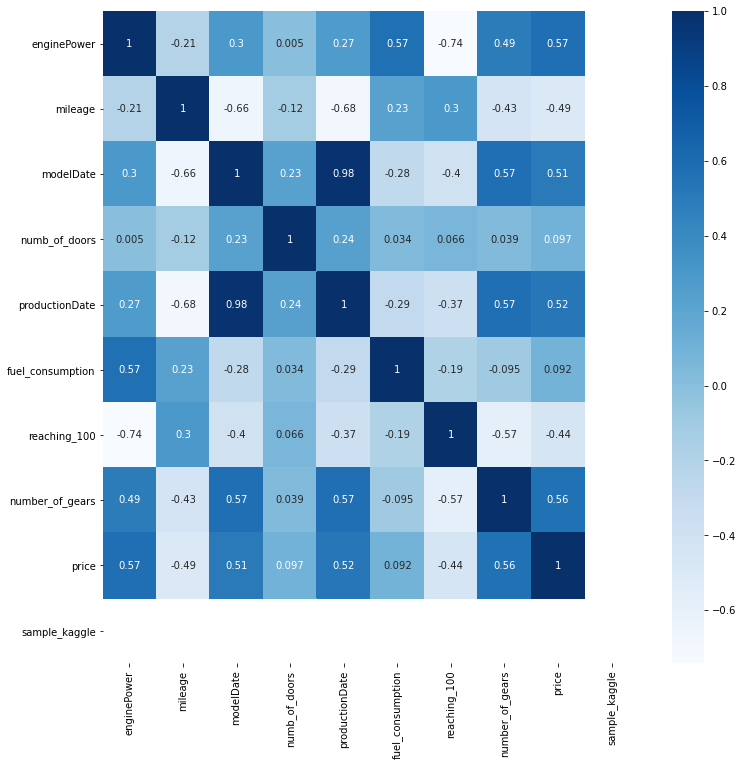

In [35]:
plt.figure(figsize=(12,12))
sns.heatmap(data[data.sample_kaggle == 1].corr(), annot=True, cmap='Blues')





**We can see from the chart above that the 'enginePower' has highest correlation with 'price'.
Second place in correlation to 'price' is taken by the 'number_of_gears'. 'enginePower'
and the 'number_of_gears' have high correlation with each other. Third place in correlation 
to 'price' is taken by 'reaching_100'. It can be seen from the chart that the numerical features 
correlated with the target variable and with each other, except for the 'numb_of_doors'. 
The release date of the car and the release of the model are very correlated, I will choose one
of them for model building.**

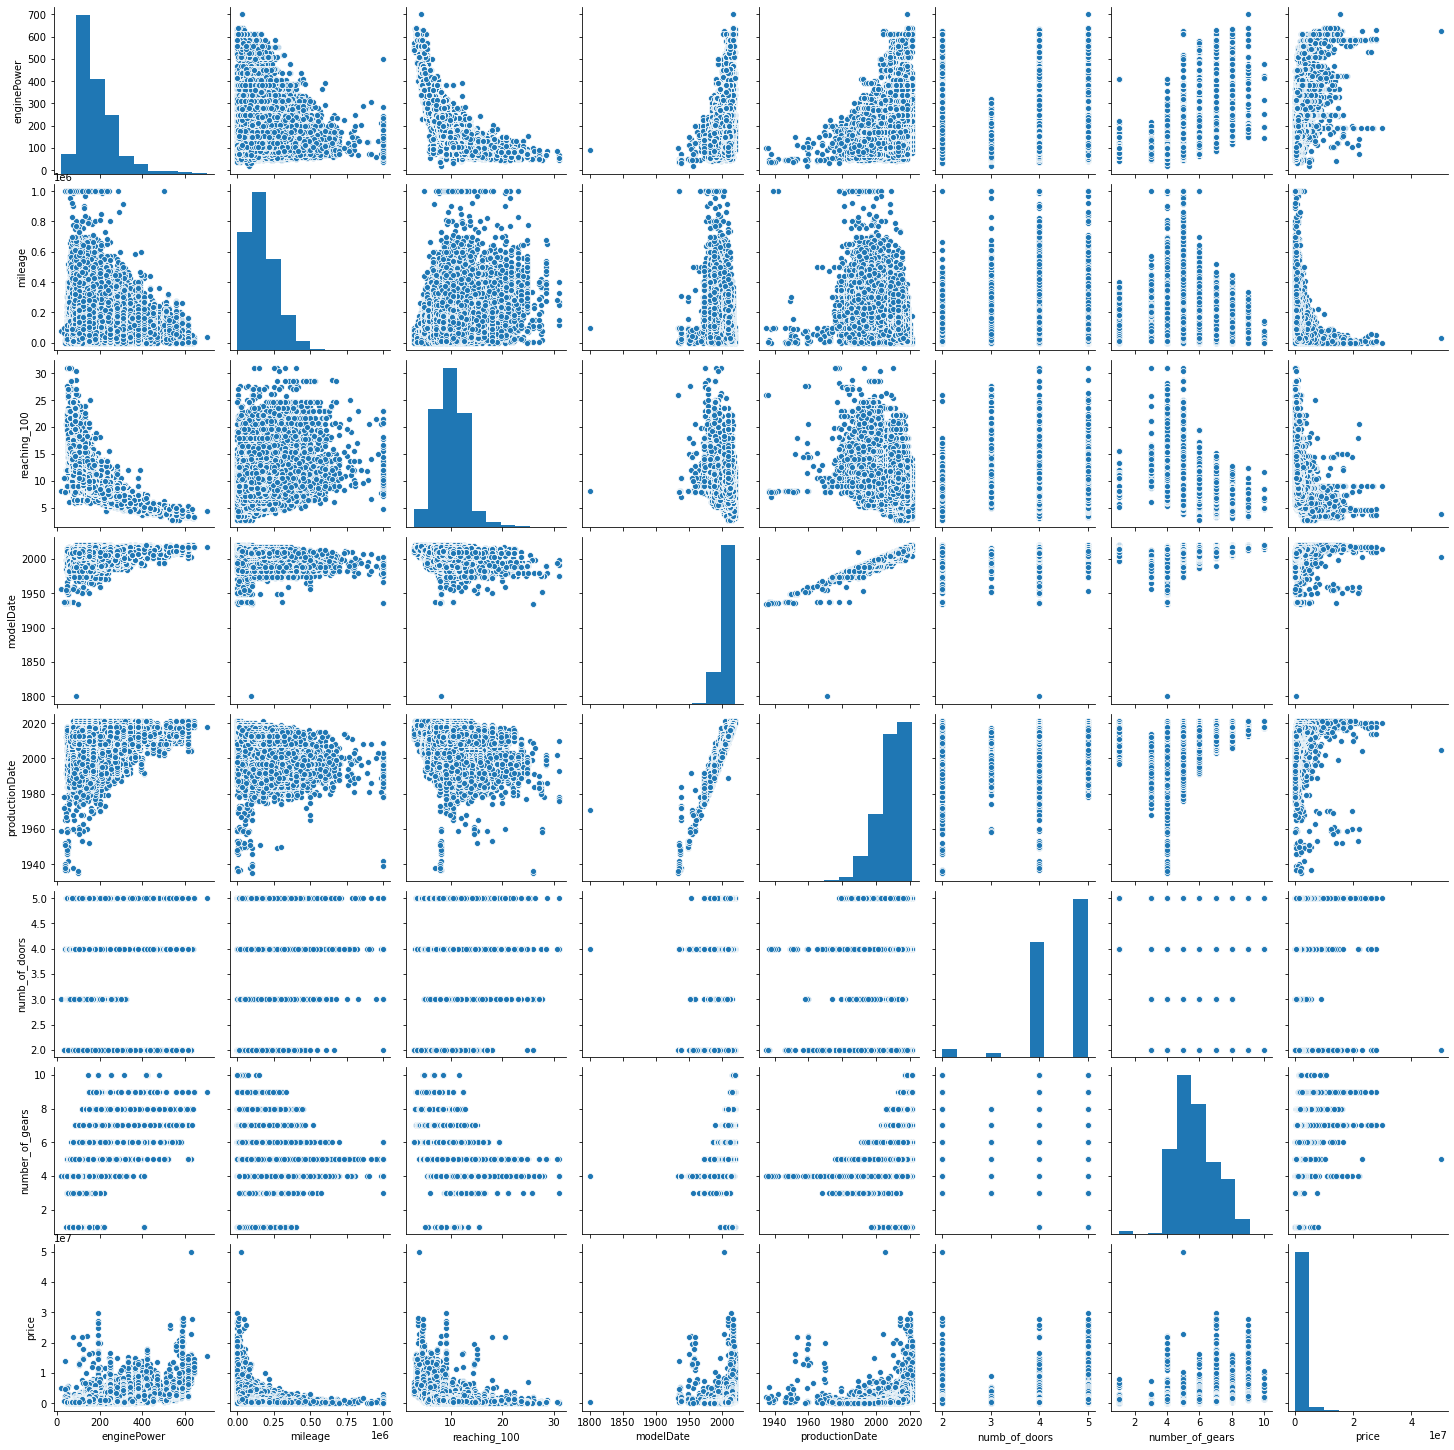

In [36]:
sns.pairplot(data[data.sample_kaggle == 1][['enginePower', 'mileage', 'reaching_100', 'modelDate', 
                     'productionDate', 'numb_of_doors', 'number_of_gears', 'price']])



**In my opinion the graph above shows some expected observations.
Cars with powerful engines are more often built recently and they have less miles. 
Some people can keep sport cars in garages for weekends, and they drive other cars on weekdays. 
The faster the car accelerates, the greater likelyhood of morepowerful engine in it, 
although there are other factors, such as the weight of the car for example. 
The less miles on a car the higher price you can get for it.  A lot of gears
are more common on fast-accelerating cars. High price is also more common on fast
acceleration cars.**

# Target Variable 'price' <a id="target"></a>

count    8.832400e+04
mean     1.339716e+06
std      1.556005e+06
min      2.000000e+04
25%      4.300000e+05
50%      8.700000e+05
75%      1.680000e+06
max      5.000000e+07
Name: price, dtype: float64

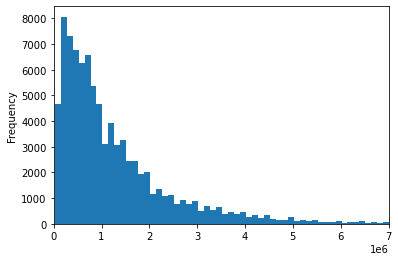

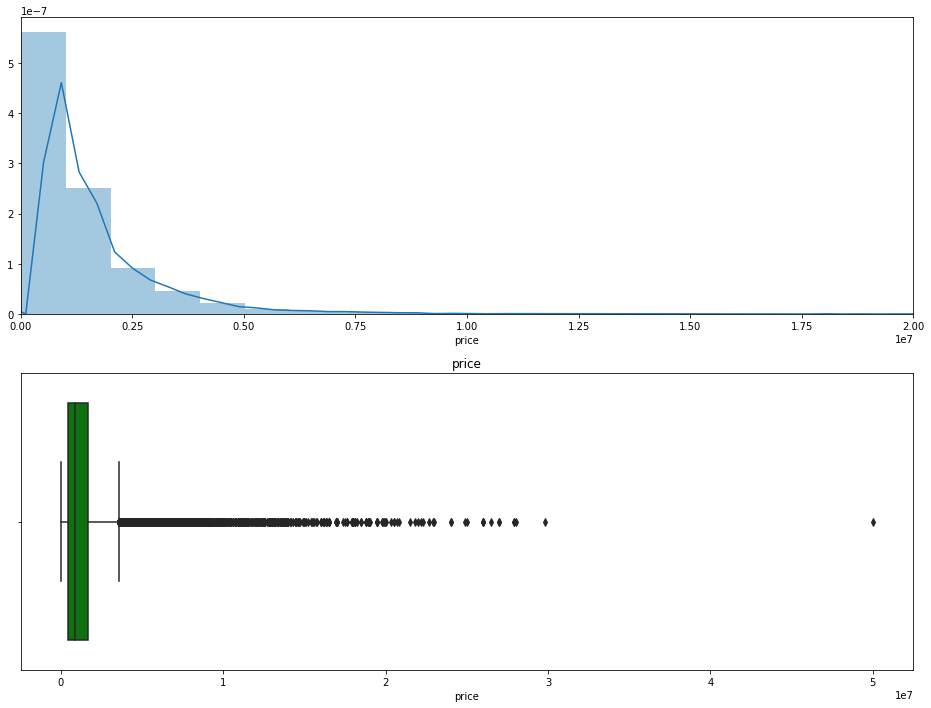

In [37]:
numerical_columns_anaylysis(data, 'price', 400, log='no')

In [38]:

# We can see the distribution of target variable far from normal.

In [39]:
finding_outliers(data,'price', log ='no')

7354

In [40]:
# Price distribution has about 10% of outliers.


count    88324.000000
mean        13.625535
std          1.023490
min          9.903488
25%         12.971540
50%         13.676248
75%         14.334304
max         17.727534
Name: price, dtype: float64

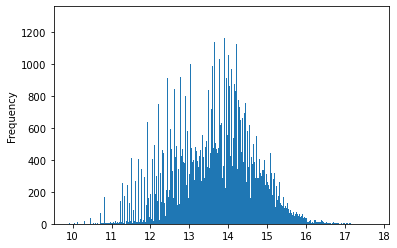

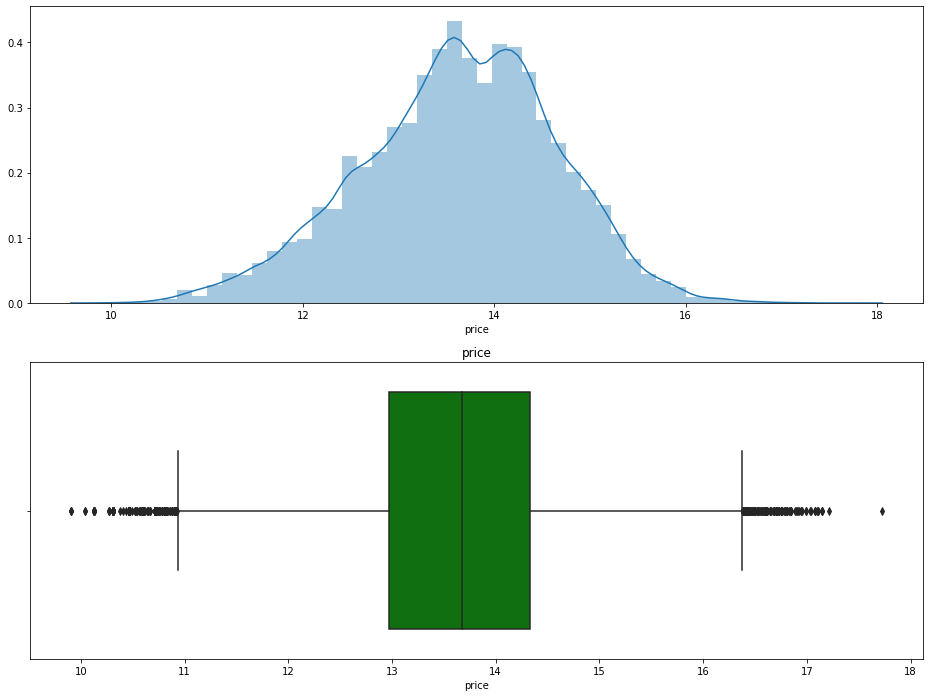

In [41]:
numerical_columns_anaylysis(data, 'price', 400, log='yes')

In [42]:
# After I applied logarithmic function to 'price', its distribution became
# much more normal. I will experiment with it in the model building.


In [43]:
finding_outliers(data,'price', log ='yes')

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


34686

In [44]:

#I got much more outliers after using log function.

# Numeric Features <a id="number"></a>

# 'enginePower'

count    123010.000000
mean        183.358199
std          87.378098
min          19.000000
25%         122.000000
50%         163.000000
75%         225.000000
max         700.000000
Name: enginePower, dtype: float64

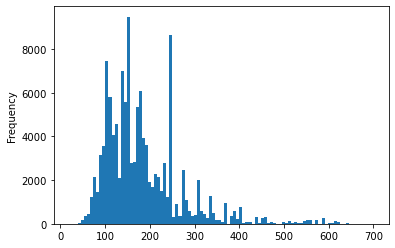

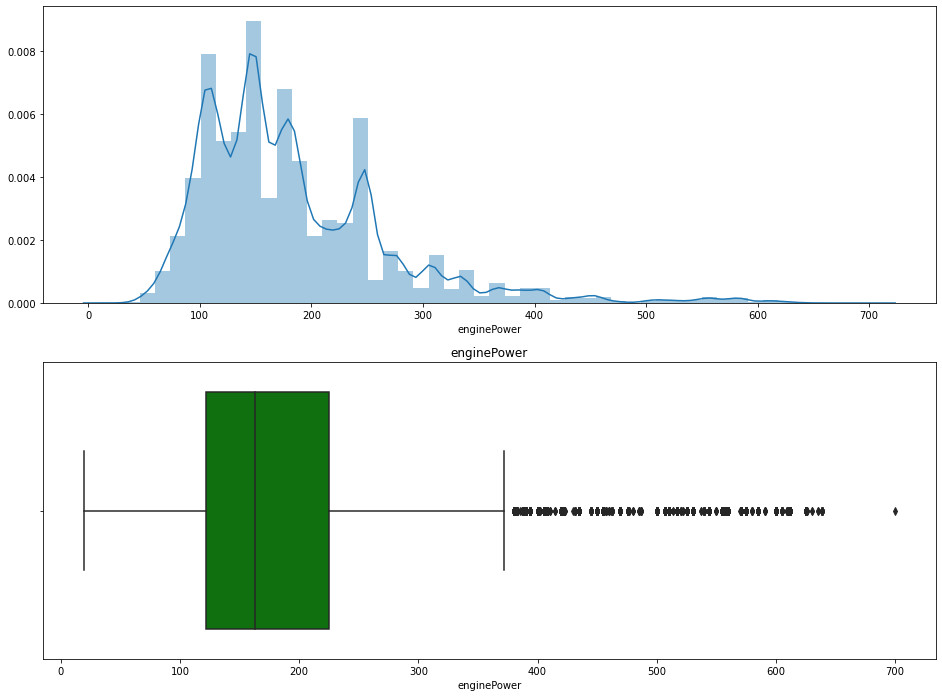

In [45]:
numerical_columns_anaylysis(data, 'enginePower', 100, log='no')


In [46]:

# The 'enginePower'distribution is far from normal. Its mean significantly greater
# than its median and it has a lot of outliers on the right.

finding_outliers(data,'enginePower', log ='no')

4794

count    123010.000000
mean          5.115366
std           0.430220
min           2.944439
25%           4.804021
50%           5.093750
75%           5.416100
max           6.551080
Name: enginePower, dtype: float64

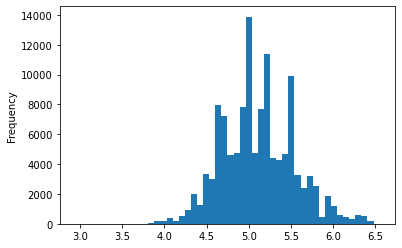

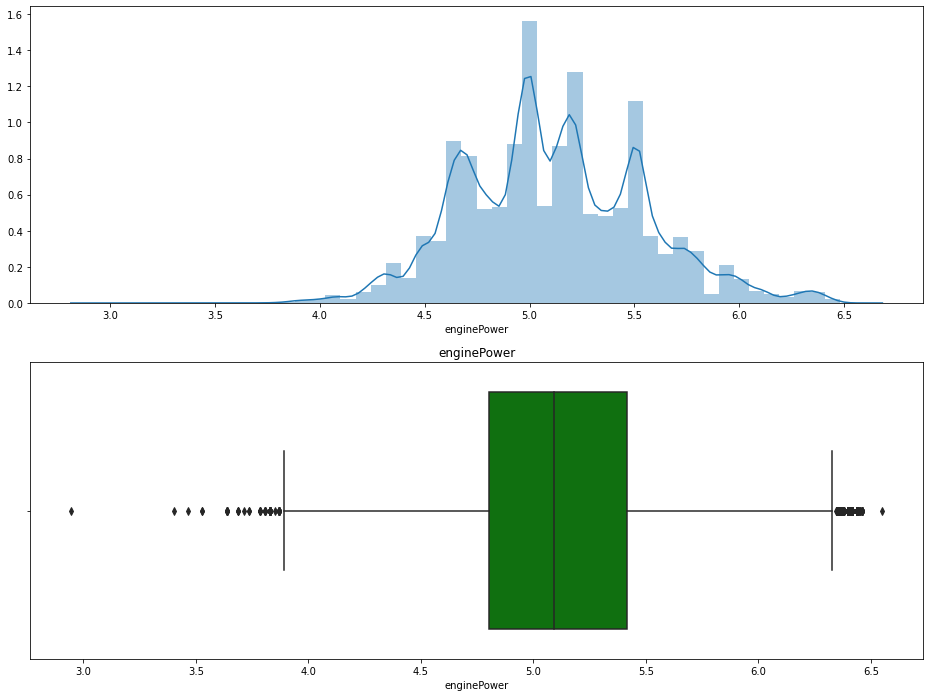

In [47]:
# The amount of outliers is about 14000, 6%.
# Lets check it distribution after applying log function to it.


numerical_columns_anaylysis(data, 'enginePower', 50, log='yes')

In [48]:
finding_outliers(data,'enginePower', log='yes')

809

In [49]:
# The graph above shows distribution of 'enginePower' is much more normal
# after applying log function to it. Plus it got less outliers. I will check
# if this will get greater prediction in the model.



# 'number_of_gears'

count    123010.000000
mean          5.807821
std           1.356389
min           1.000000
25%           5.000000
50%           6.000000
75%           7.000000
max          10.000000
Name: number_of_gears, dtype: float64

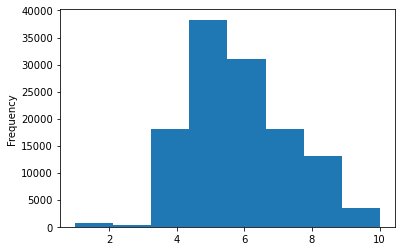

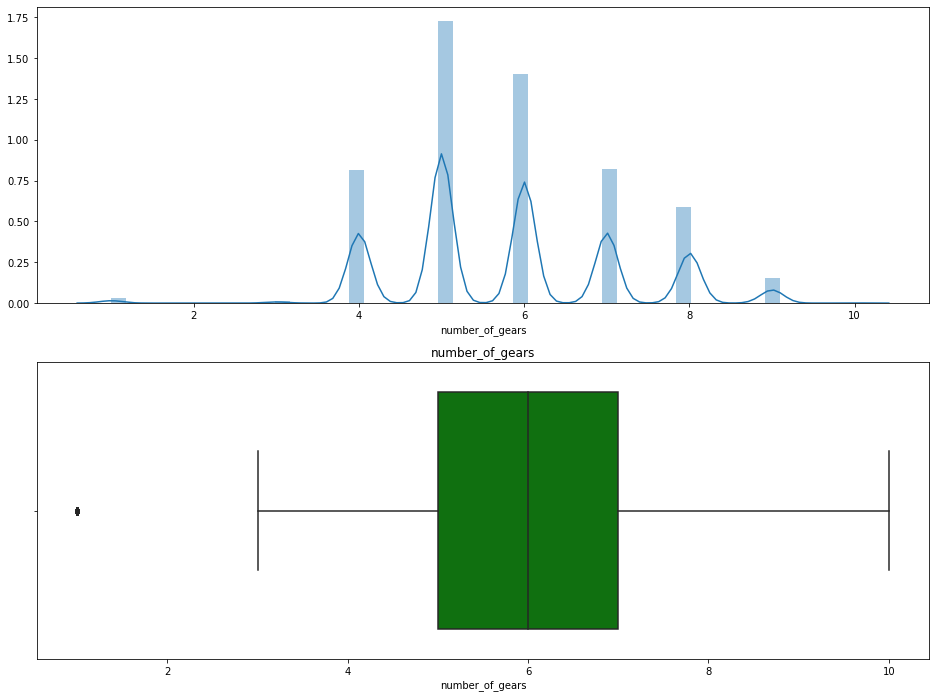

In [50]:
numerical_columns_anaylysis(data, 'number_of_gears', 8, log='no')

In [51]:


# I can try to convert this feature to categorical one and check if it
# iproves results

finding_outliers(data,'number_of_gears', log='no')

663

In [52]:

data.number_of_gears.value_counts()

5.0     38293
6.0     31043
7.0     18149
4.0     18060
8.0     13054
9.0      3454
1.0       624
3.0       294
10.0       39
Name: number_of_gears, dtype: int64

#  'reaching_100'

count    123010.000000
mean          9.884547
std           2.785349
min           2.800000
25%           7.900000
50%           9.700000
75%          11.700000
max          32.300000
Name: reaching_100, dtype: float64

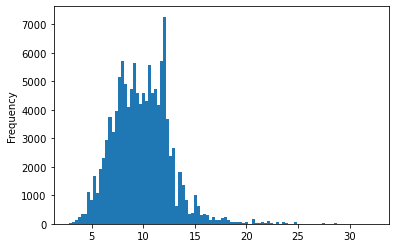

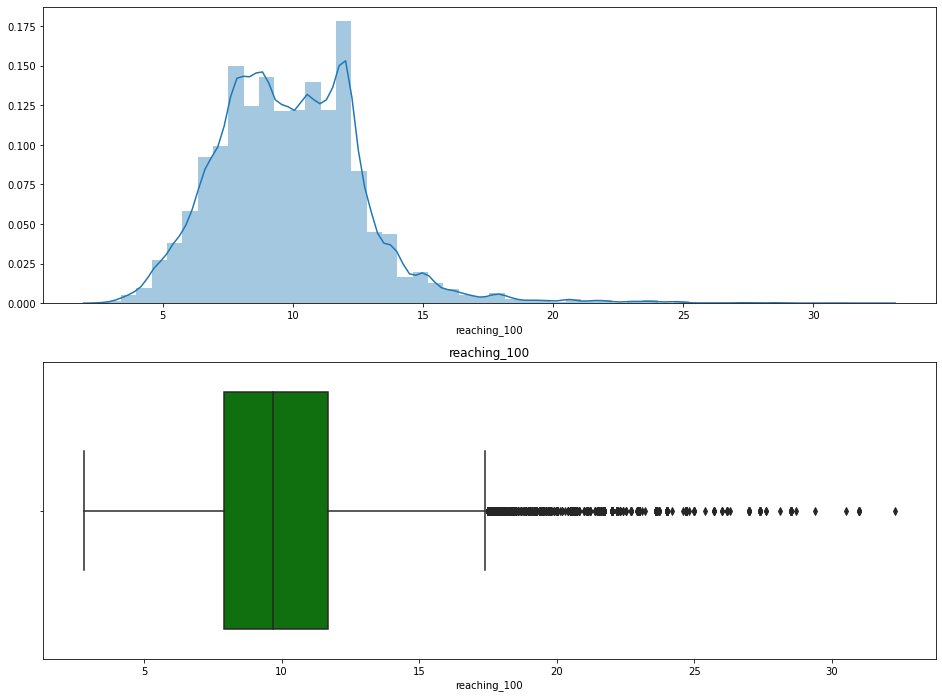

In [53]:
numerical_columns_anaylysis(data, 'reaching_100', 100, log='no')

In [54]:

# The given distribution above is much more normal than prior feature distributions.
# It has mean and median very close.

In [55]:
finding_outliers(data,'reaching_100', log='no')

1863

count    123010.000000
mean          2.251576
std           0.284166
min           1.029619
25%           2.066863
50%           2.272126
75%           2.459589
max           3.475067
Name: reaching_100, dtype: float64

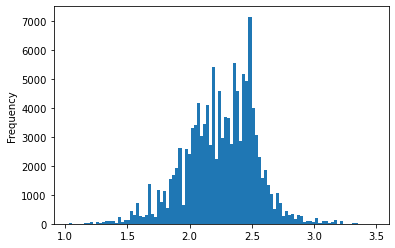

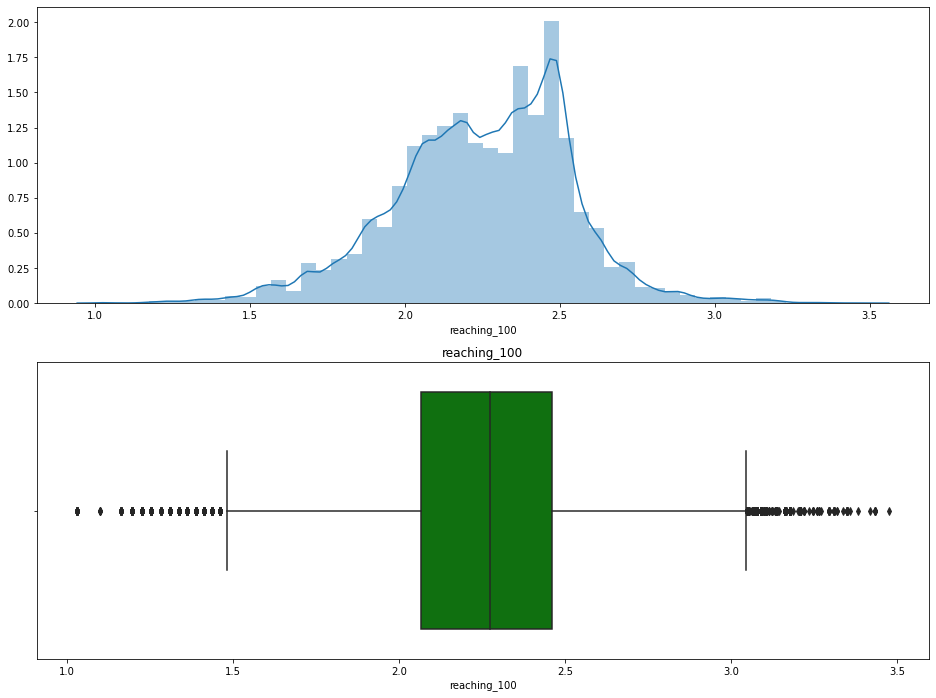

In [56]:
# Lets check it after using logaritmic function.
numerical_columns_anaylysis(data, 'reaching_100', 100, log='yes')

In [57]:
finding_outliers(data,'reaching_100', log='yes')

1493

In [58]:
# After applying log function 'reaching_100' it got less outliers.
# I will experiment with it during model building 



# 'productionDate'

count    123010.000000
mean       2008.960011
std           7.820615
min        1904.000000
25%        2005.000000
50%        2011.000000
75%        2015.000000
max        2021.000000
Name: productionDate, dtype: float64

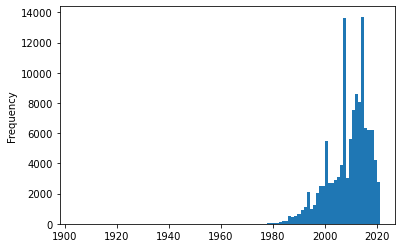

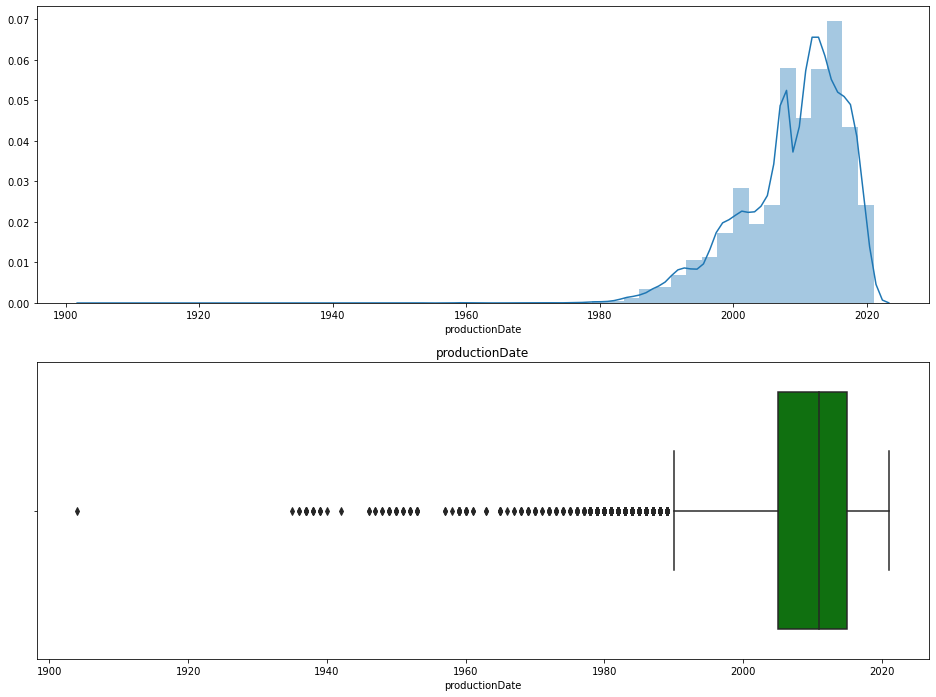

In [59]:
numerical_columns_anaylysis(data, 'productionDate', 100, log='no')

In [60]:
# Collected data has much more cars manufactured after 2000.
# 'productionDate' Distribution doesn't resemble normal distribution.


In [61]:
finding_outliers(data,'productionDate', log='no')

2968

In [62]:
# Majority of outliers are the car manufactured before 1990.


# 'mileage'

count     123010.000000
mean      169013.170303
std       106523.147481
min            1.000000
25%        92000.000000
50%       155000.000000
75%       228600.750000
max      1000000.000000
Name: mileage, dtype: float64

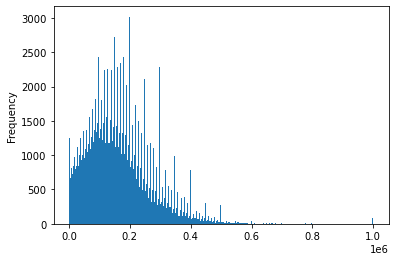

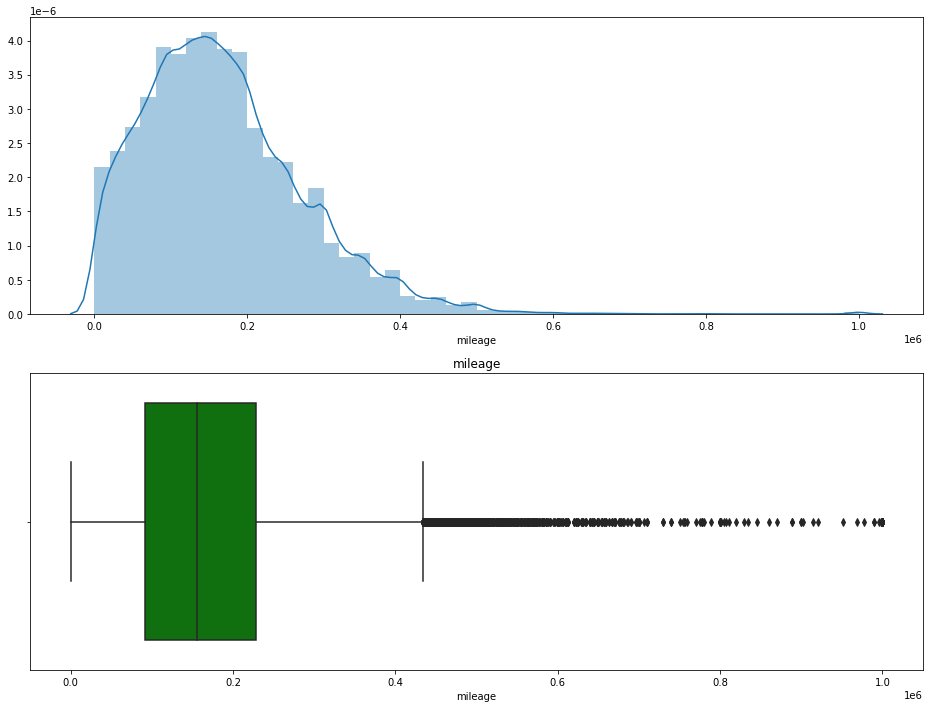

In [63]:
numerical_columns_anaylysis(data, 'mileage', 300, log='no')

In [64]:
# Some cars have no mileage. It means they are new and got into used
# category by accident or some of these cars have been kept in garage.
# I have to check manufacturing year to find out.

In [65]:
finding_outliers(data,'mileage', log='no')

2229

In [66]:
# This feature has less outliers than other, it has 2.5% of outliers.



count    123010.000000
mean         11.743860
std           1.036303
min           0.000000
25%          11.429544
50%          11.951180
75%          12.339732
max          13.815511
Name: mileage, dtype: float64

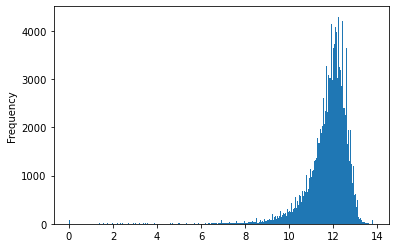

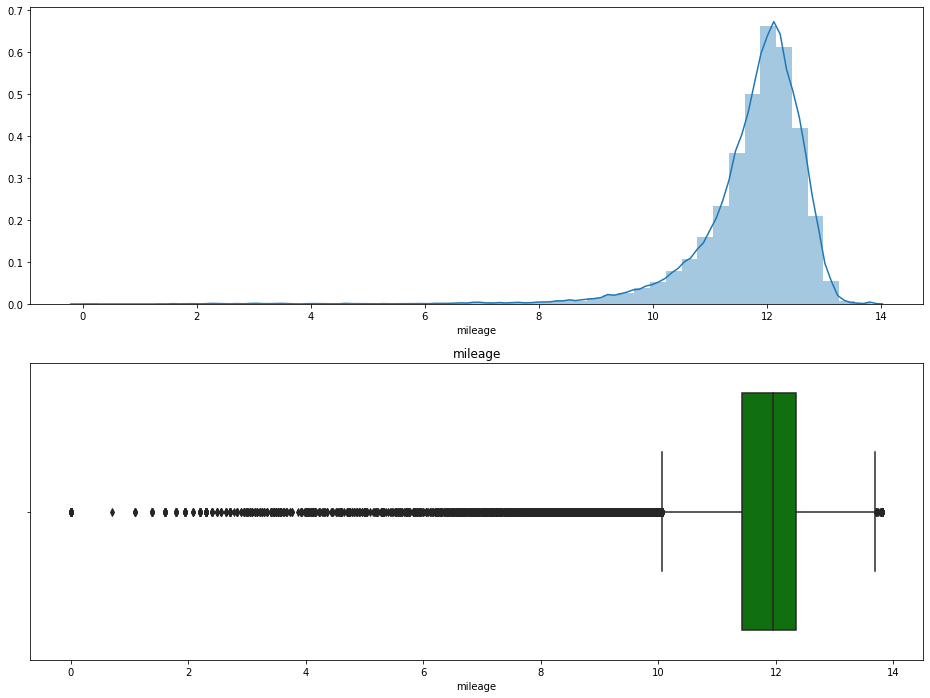

In [67]:
numerical_columns_anaylysis(data, 'mileage', 300, log='yes')

In [68]:

# After applying log function the distribution became more symmetryc

In [69]:
finding_outliers(data,'mileage', log='yes')

6174

In [70]:
# But number of outliers increased

# 'modelDate'

count    123010.000000
mean       2006.813438
std           8.187160
min        1800.000000
25%        2002.000000
50%        2009.000000
75%        2013.000000
max        2021.000000
Name: modelDate, dtype: float64

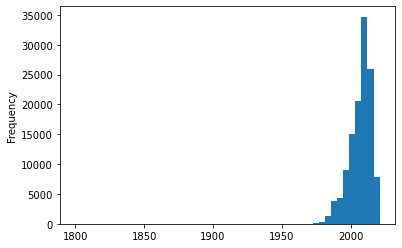

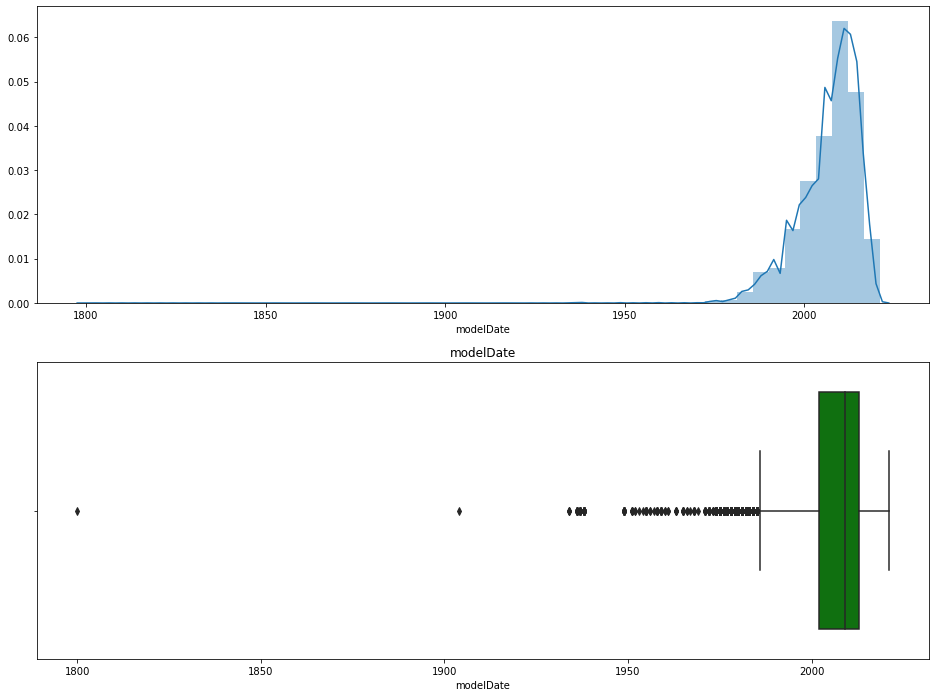

In [71]:
numerical_columns_anaylysis(data, 'modelDate', 50, log='no')

In [72]:
# This data contains models produced in 2021. If it's not mistake, they are
# new vehicles or some decided to get rid of them after the purchase.



In [73]:
finding_outliers(data,'modelDate', log='no')

2035

# ****Categorical Features  <a id="category"></a>

# 'brand'

toyota        19398
nissan        16652
mercedes      16508
bmw           15650
volkswagen    15355
audi           9887
mitsubishi     8537
skoda          6990
honda          4425
lexus          3743
volvo          3553
infiniti       2312
Name: brand, dtype: int64

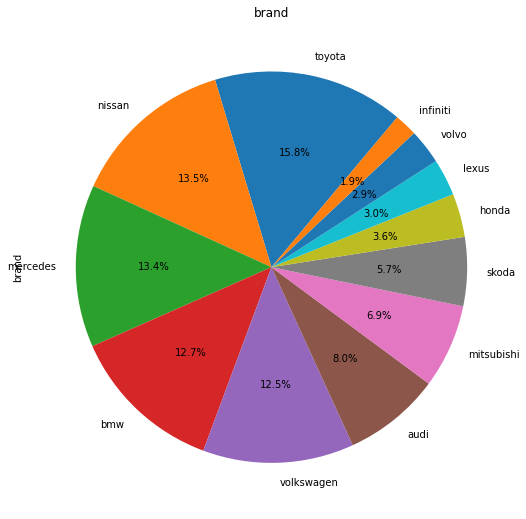

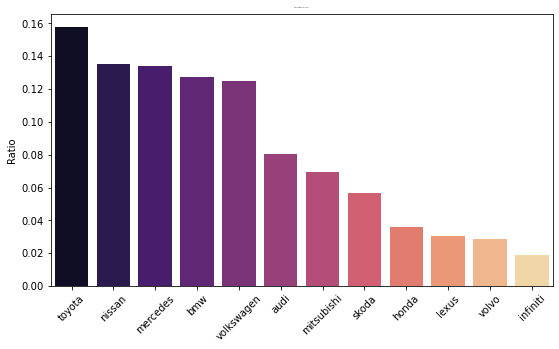

In [74]:
category_ratio(data, 'brand', 25)

In [75]:
# The data contains 35 different brands. 7 brands are 50% of collected cars.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


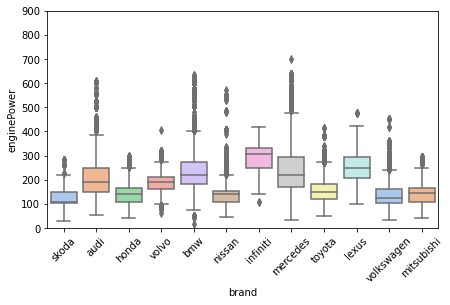

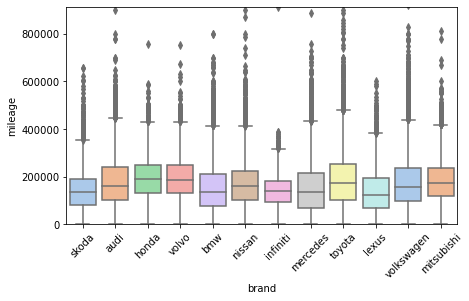

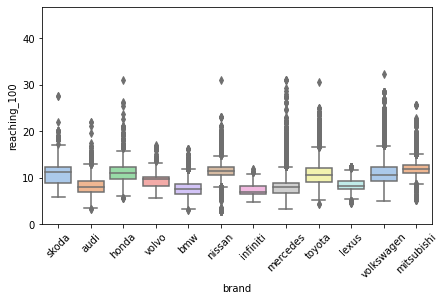

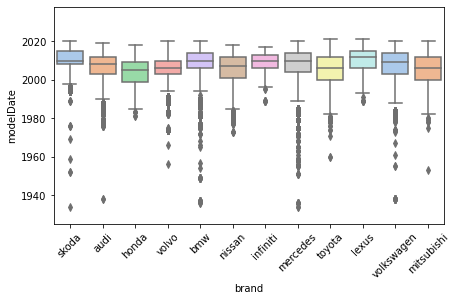

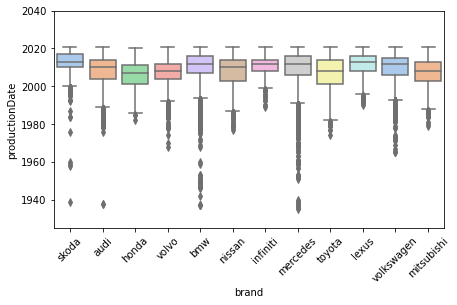

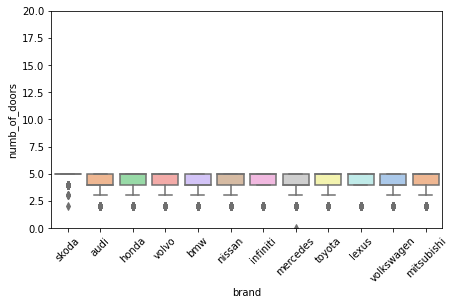

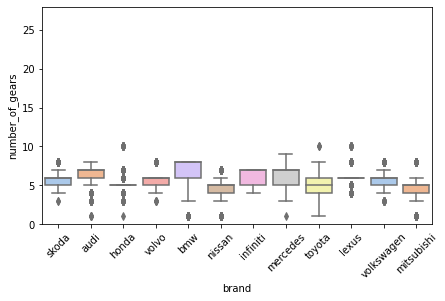

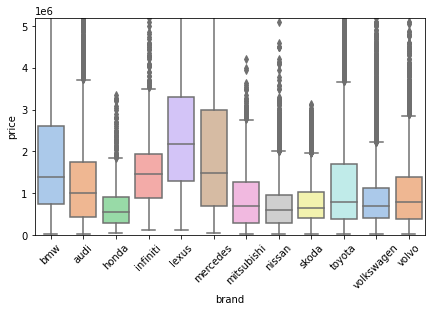

In [76]:
category_over_numeric_features('brand', 12)

In [77]:
# The graph above shows noticable statistical significance defference for
# 'brand' and 'price'. But still we have to use statistical method to check it.


In [78]:
# The function call below will reveal if there statistically significant difference
# exists for 'brand' in relationship to target variable and other numerical features.
# It might help to engineer new features for better results.

numeric_clmns = ['enginePower', 'mileage', 'reaching_100', 'modelDate', 
                     'productionDate', 'numb_of_doors', 'number_of_gears', 'price']

get_stat_dif('brand', data, numeric_clmns)

Noticable statisctical significance found for  brand   in relationship to   enginePower
Noticable statisctical significance found for  brand   in relationship to   mileage
Noticable statisctical significance found for  brand   in relationship to   reaching_100
Noticable statisctical significance found for  brand   in relationship to   modelDate
Noticable statisctical significance found for  brand   in relationship to   productionDate
Noticable statisctical significance found for  brand   in relationship to   numb_of_doors
Noticable statisctical significance found for  brand   in relationship to   number_of_gears
Noticable statisctical significance found for  brand   in relationship to   price


In [79]:
# 'brand' has statistically significant differences in 8 numerical features.

# 'bodyType'

седан                      45913
внедорожник 5 дв.          44600
хэтчбек 5 дв.               7881
лифтбек                     5933
универсал 5 дв.             5146
минивэн                     3653
купе                        2505
компактвэн                  2361
хэтчбек 3 дв.               1497
пикап двойная кабина        1143
купе-хардтоп                 517
фургон                       505
внедорожник 3 дв.            418
родстер                      297
кабриолет                    253
седан-хардтоп                220
микровэн                      74
седан 2 дв.                   26
пикап одинарная кабина        22
пикап полуторная кабина       18
внедорожник открытый          11
лимузин                       10
тарга                          3
универсал 3 дв.                3
фастбек                        1
Name: bodyType, dtype: int64

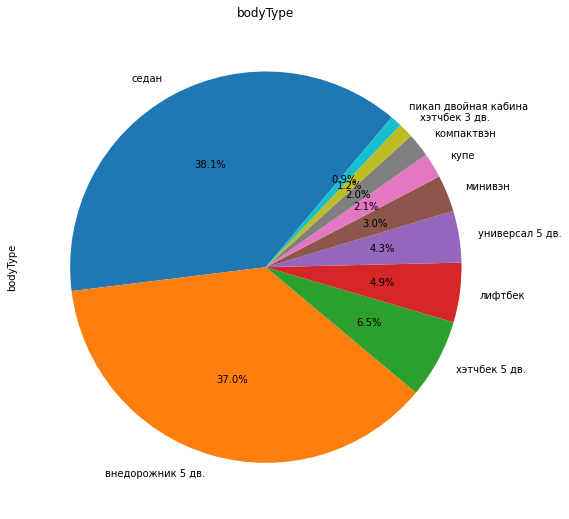

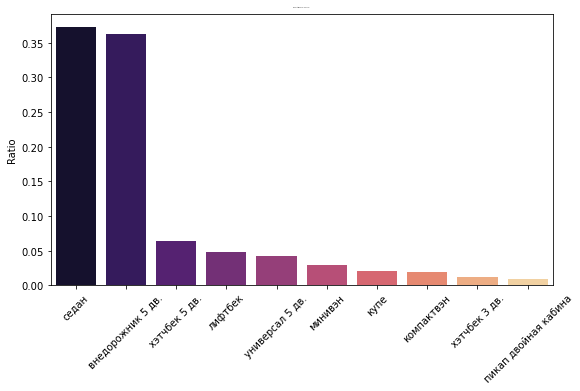

In [80]:
category_ratio(data, 'bodyType', 10)

In [81]:
# Given data has 27 kinds of auto body types, but 80% of collected listings
# have 3 body types. I will experiment and I might delete some rows with 
# very rare body types.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


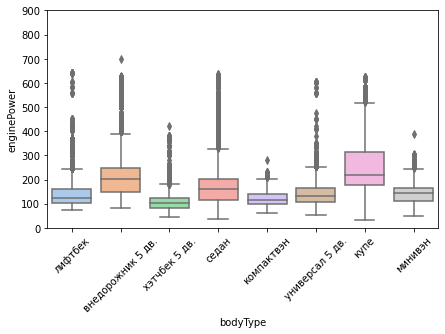

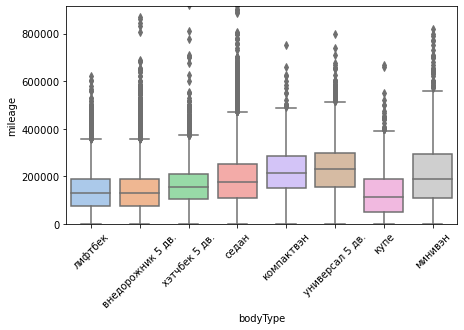

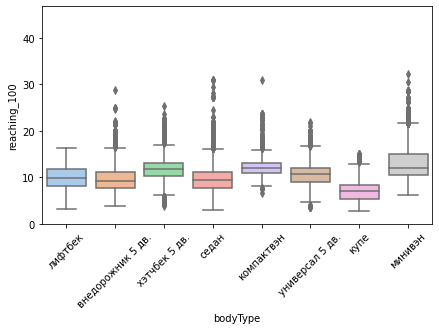

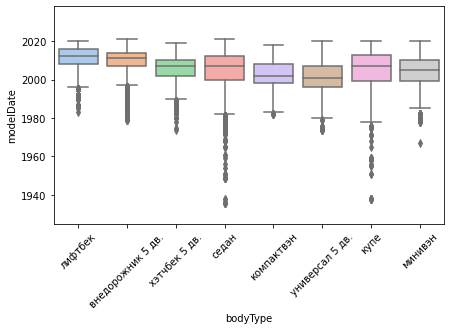

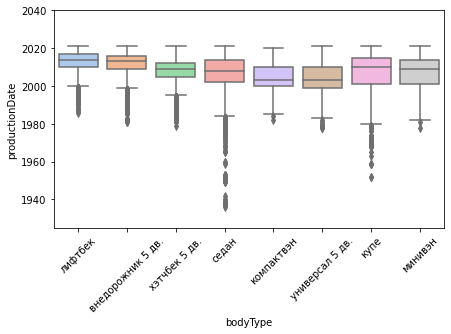

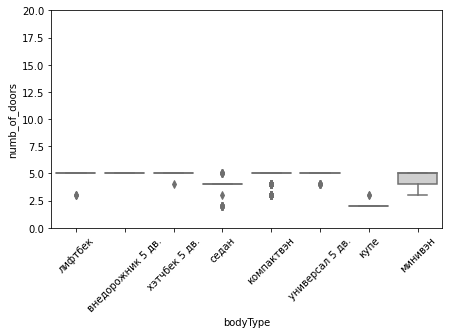

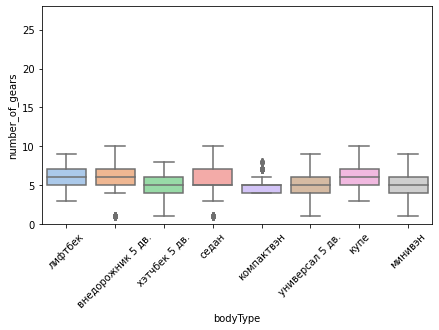

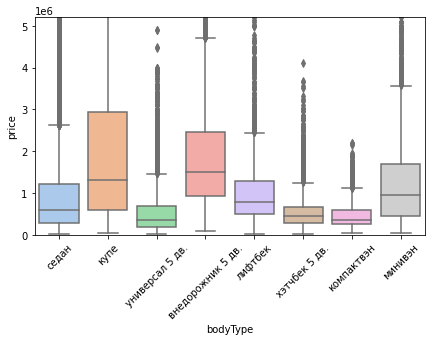

In [82]:
category_over_numeric_features('bodyType', 8)

In [83]:
# The graph above suggests the 'bodyType' has significant statistical difference in
# target variable, but I will check it.

In [84]:
get_stat_dif('bodyType', data, numeric_clmns)

Noticable statisctical significance found for  bodyType   in relationship to   enginePower
Noticable statisctical significance found for  bodyType   in relationship to   mileage
Noticable statisctical significance found for  bodyType   in relationship to   reaching_100
Noticable statisctical significance found for  bodyType   in relationship to   modelDate
Noticable statisctical significance found for  bodyType   in relationship to   productionDate
Noticable statisctical significance found for  bodyType   in relationship to   numb_of_doors
Noticable statisctical significance found for  bodyType   in relationship to   number_of_gears
Noticable statisctical significance found for  bodyType   in relationship to   price


In [85]:
# 'bodyType' has statistically significant differences in 8 numerical features.

# 'color'

чёрный         36441
белый          25232
серый          15413
серебристый    14849
синий          10920
красный         5304
коричневый      4641
зелёный         3368
бежевый         1918
голубой         1480
золотистый       948
фиолетовый       764
пурпурный        727
жёлтый           545
оранжевый        389
розовый           71
Name: color, dtype: int64

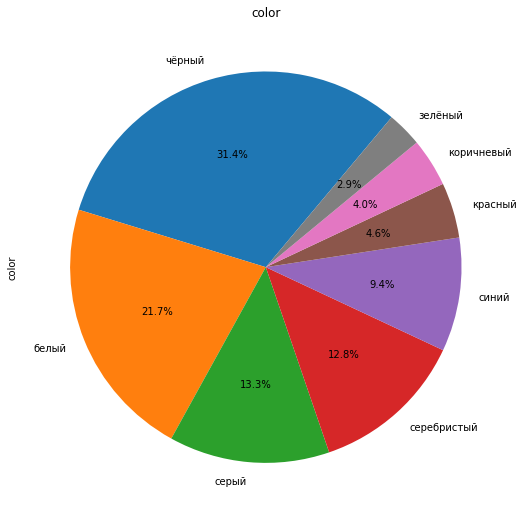

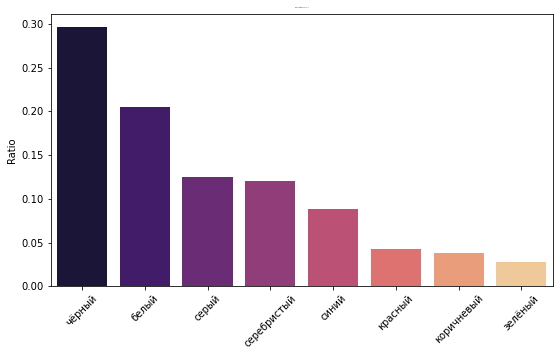

In [86]:
category_ratio(data, 'color', 8)

In [87]:
# Given data contains 16 different colors, 75% of collected listings
# have 4 colors.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


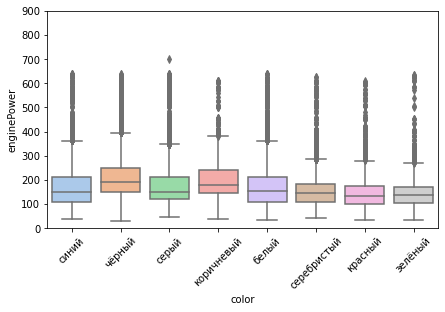

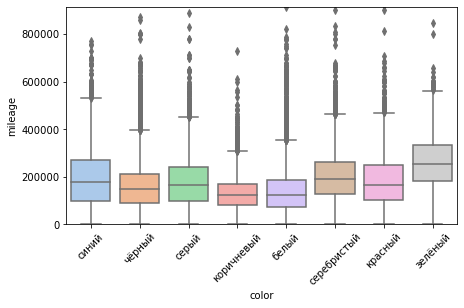

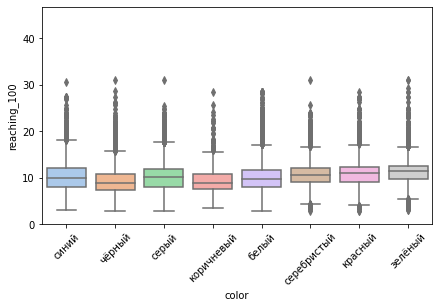

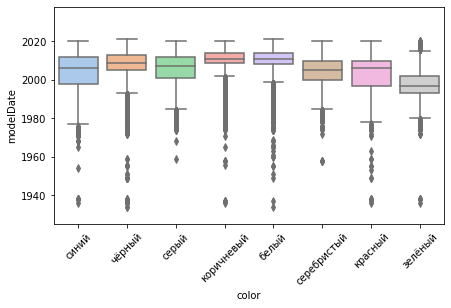

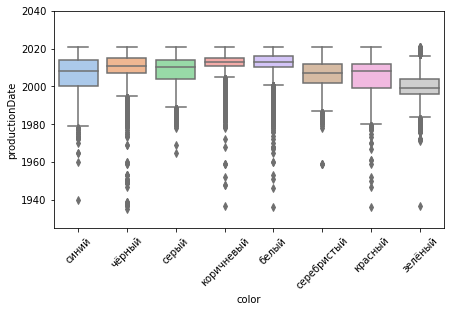

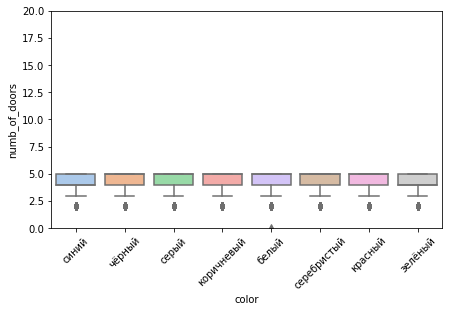

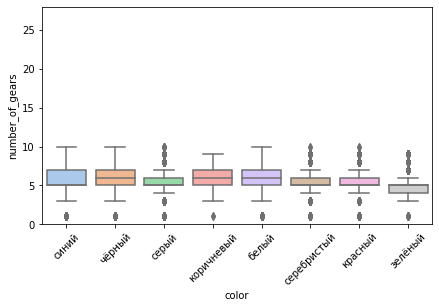

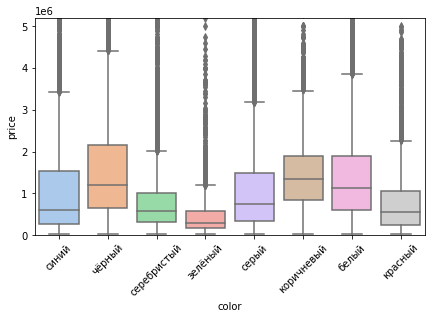

In [88]:
category_over_numeric_features('color', 8)

In [89]:
# The graph above suggests the 'color' has significant statistical difference in
# target variable, but I will check it.

In [90]:
get_stat_dif('color', data, numeric_clmns)

Noticable statisctical significance found for  color   in relationship to   enginePower
Noticable statisctical significance found for  color   in relationship to   mileage
Noticable statisctical significance found for  color   in relationship to   reaching_100
Noticable statisctical significance found for  color   in relationship to   modelDate
Noticable statisctical significance found for  color   in relationship to   productionDate
Noticable statisctical significance found for  color   in relationship to   numb_of_doors
Noticable statisctical significance found for  color   in relationship to   number_of_gears
Noticable statisctical significance found for  color   in relationship to   price


In [91]:
# 'color' has statistically significant differences in 8 numerical features.

# 'engineDisplacement'

2.0    27795
1.6    16540
3.0    13800
1.8    10681
2.5     8604
3.5     5522
1.4     5411
2.4     5213
1.5     4292
1.3     1786
1.2     1633
2.8     1522
4.5     1460
4.4     1320
2.2     1292
4.7     1202
4.0     1187
3.2     1184
5.5     1130
2.1     1016
2.7      878
2.3      862
1.9      817
4.2      790
3.6      634
3.7      632
1.0      599
5.7      576
5.0      516
5.6      507
2.9      461
4.6      454
0.7      345
1.7      281
4.8      259
3.1      237
2.6      231
3.3      196
3.8      155
6.0      141
3.4      135
4.3      129
6.2      125
5.4      104
4.1      101
          55
0.0       48
5.2       32
5.9       27
5.8       25
6.6       20
1.1       14
4.9       13
6.3       12
3.9        7
0.6        1
5.3        1
Name: engineDisplacement, dtype: int64

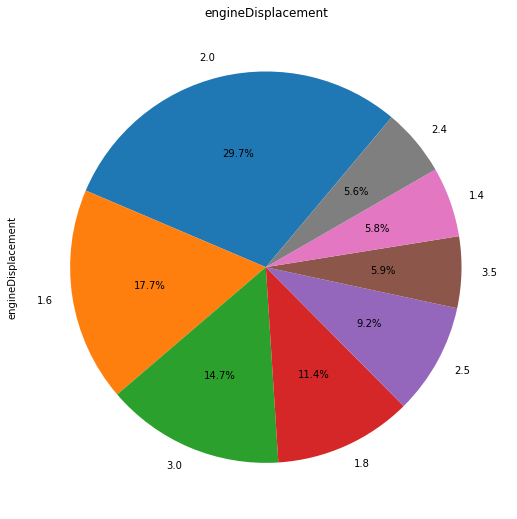

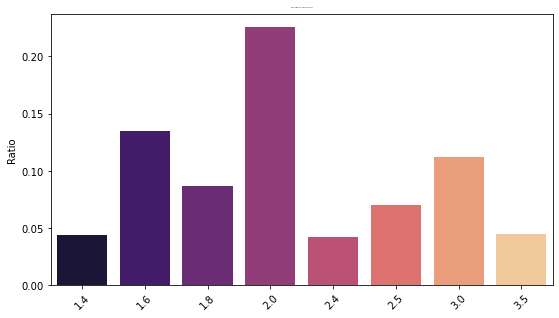

In [92]:
category_ratio(data, 'engineDisplacement', 8)

In [93]:
# Given data has 67 kinds of engine displacements, but 60% of collected listings
# have 6 different engine displacements. I will experiment and I might delete some rows with 
# very rare engine displacements.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


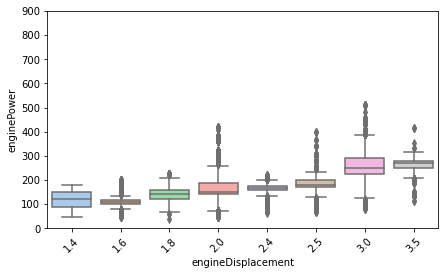

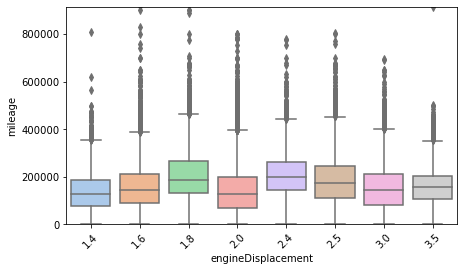

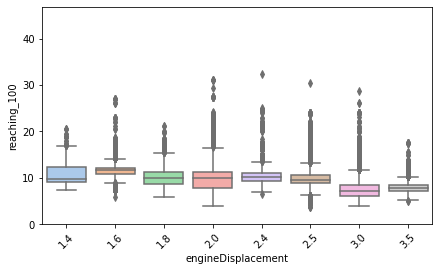

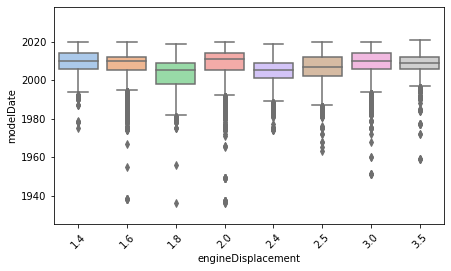

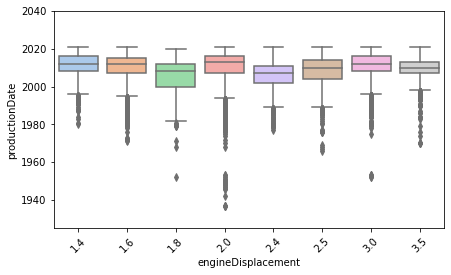

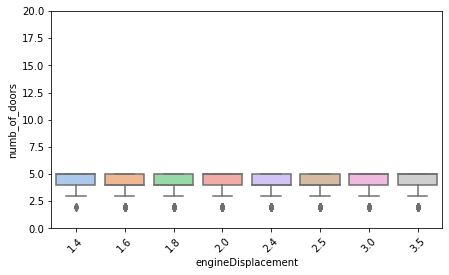

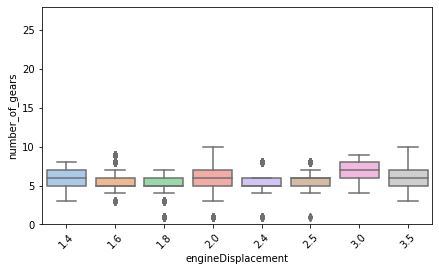

In [94]:
category_over_numeric_features('engineDisplacement', 8)

In [95]:
get_stat_dif('engineDisplacement', data, numeric_clmns)

Noticable statisctical significance found for  engineDisplacement   in relationship to   enginePower
Noticable statisctical significance found for  engineDisplacement   in relationship to   mileage
Noticable statisctical significance found for  engineDisplacement   in relationship to   reaching_100
Noticable statisctical significance found for  engineDisplacement   in relationship to   modelDate
Noticable statisctical significance found for  engineDisplacement   in relationship to   productionDate
Noticable statisctical significance found for  engineDisplacement   in relationship to   numb_of_doors
Noticable statisctical significance found for  engineDisplacement   in relationship to   number_of_gears
Noticable statisctical significance found for  engineDisplacement   in relationship to   price


In [96]:
# 'engineDisplacement' has statistically significant differences in 8 numerical features.

# 'fuelType'

бензин                                97816
дизель                                22029
гибрид                                 1644
бензин, газобаллонное оборудование     1388
электро                                 103
газ                                      30
Name: fuelType, dtype: int64

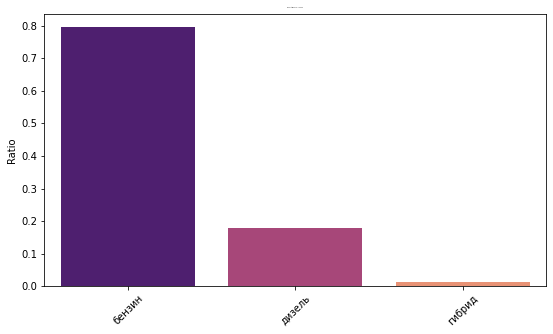

In [97]:
category_ratio(data, 'fuelType', 3)

In [98]:
# Given data has 6 kinds of fuel types. As expected 96.5% of listings have gas or diesel.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


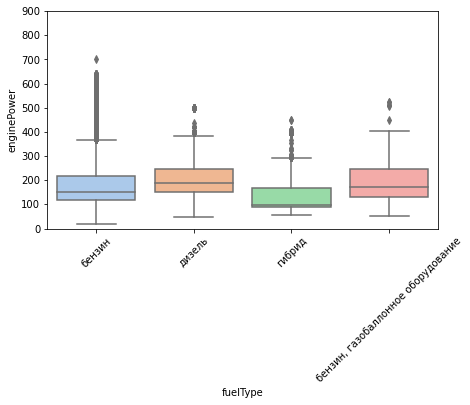

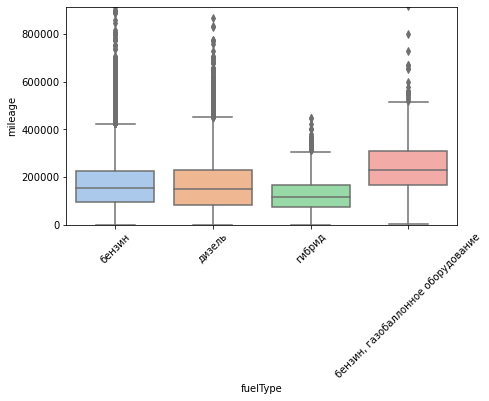

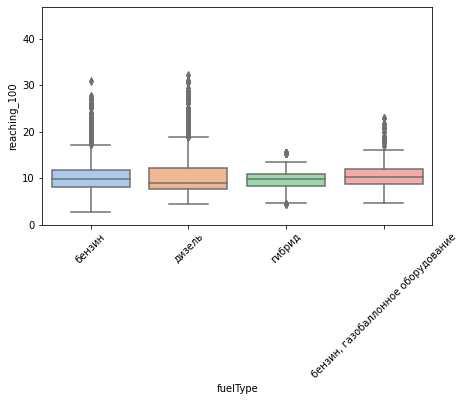

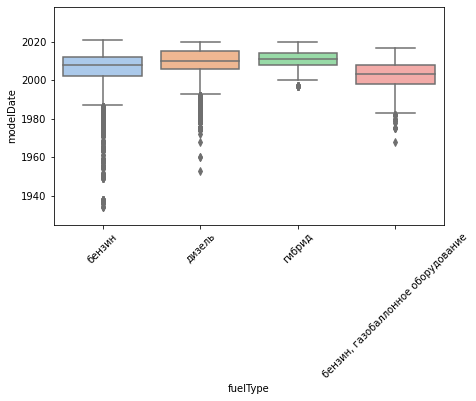

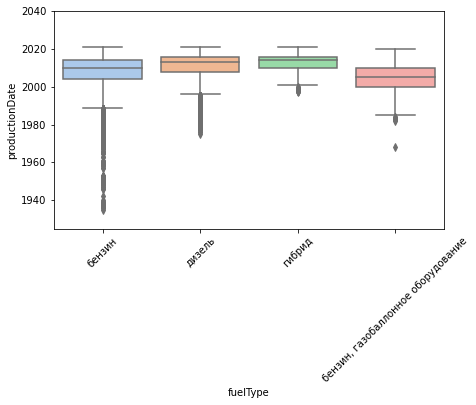

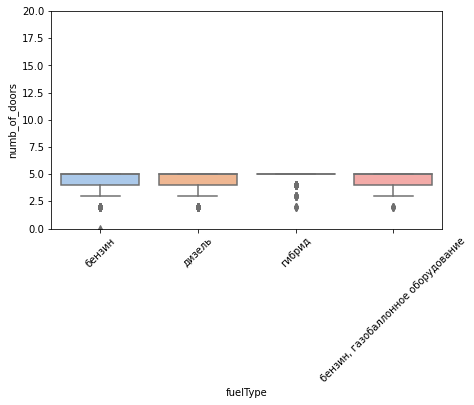

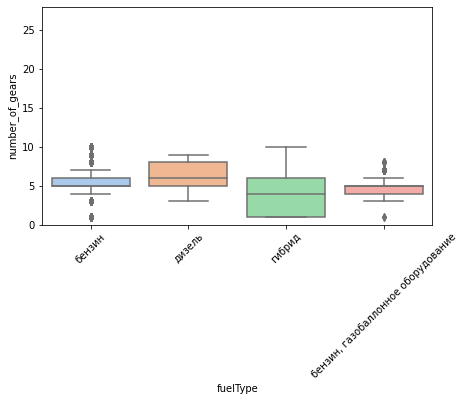

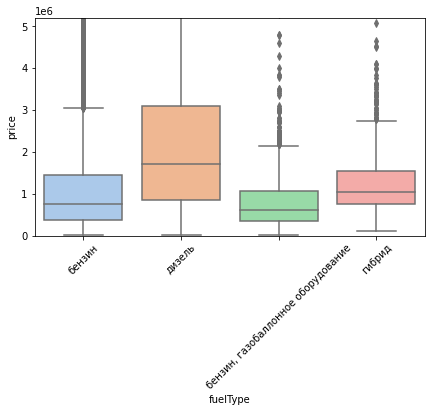

In [99]:
category_over_numeric_features('fuelType', 4)

In [100]:
# The graph above suggests the 'fuelType' has significant statistical difference in
# target variable, but I will check it.

In [101]:
get_stat_dif('fuelType', data, numeric_clmns)

Noticable statisctical significance found for  fuelType   in relationship to   enginePower
Noticable statisctical significance found for  fuelType   in relationship to   mileage
Noticable statisctical significance found for  fuelType   in relationship to   reaching_100
Noticable statisctical significance found for  fuelType   in relationship to   modelDate
Noticable statisctical significance found for  fuelType   in relationship to   productionDate
Noticable statisctical significance found for  fuelType   in relationship to   numb_of_doors
Noticable statisctical significance found for  fuelType   in relationship to   number_of_gears
Noticable statisctical significance found for  fuelType   in relationship to   price


In [102]:
# 'fuelType' has statistically significant differences in 8 numerical features.

# 'model'

5er         3696
octavia     3319
e_klasse    3239
camry       2977
polo        2914
            ... 
proace         1
nv300          1
m1             1
type_3         1
ek_space       1
Name: model, Length: 666, dtype: int64

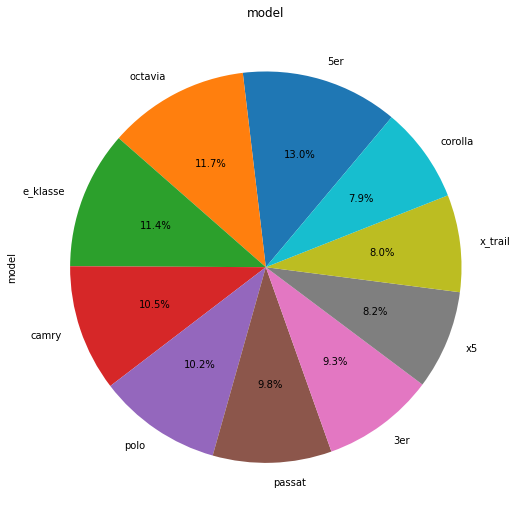

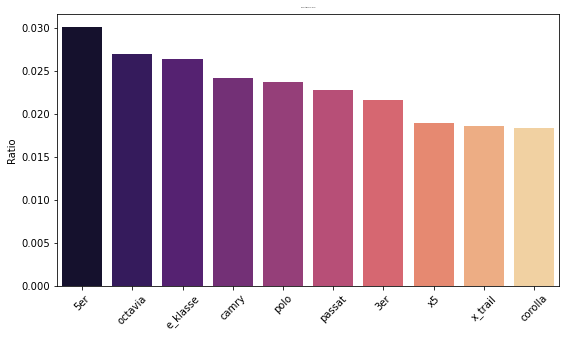

In [103]:
category_ratio(data, 'model', 10)

In [104]:
# The data has 1282 different models, but 14% of collected listings
# are 10 models. I will experiment and I might delete some rows with 
# very rare models.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


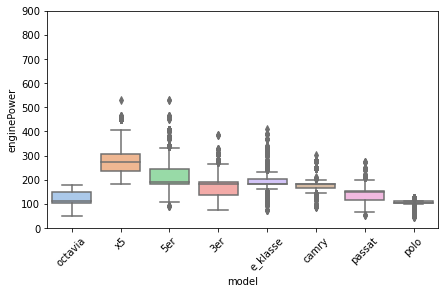

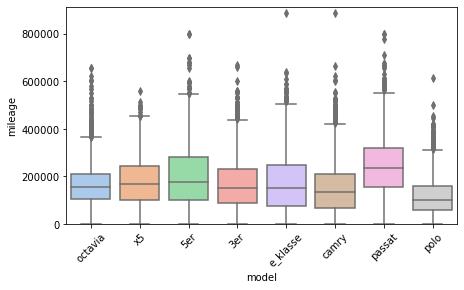

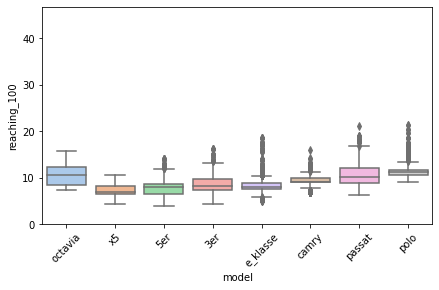

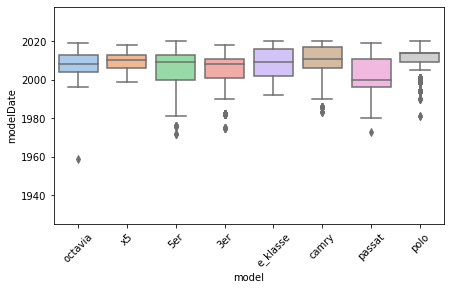

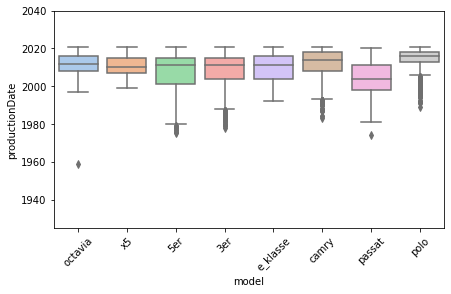

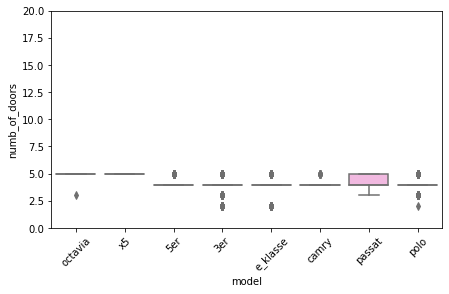

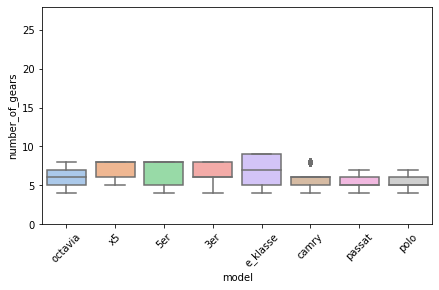

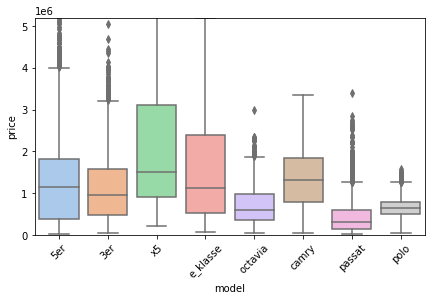

In [105]:
category_over_numeric_features('model', 8)

In [106]:
# The graph above suggests the 'model' has significant statistical difference in
# target variable, but I will check it.

In [107]:
get_stat_dif('model', data, numeric_clmns)

Noticable statisctical significance found for  model   in relationship to   enginePower
Noticable statisctical significance found for  model   in relationship to   mileage
Noticable statisctical significance found for  model   in relationship to   reaching_100
Noticable statisctical significance found for  model   in relationship to   modelDate
Noticable statisctical significance found for  model   in relationship to   productionDate
Noticable statisctical significance found for  model   in relationship to   numb_of_doors
Noticable statisctical significance found for  model   in relationship to   number_of_gears
Noticable statisctical significance found for  model   in relationship to   price


In [108]:
# 'model' has statistically significant differences in 8 numerical features.

# 'vehicleTransmission'

автоматическая      69957
механическая        26561
вариатор            15220
роботизированная    11272
Name: vehicleTransmission, dtype: int64

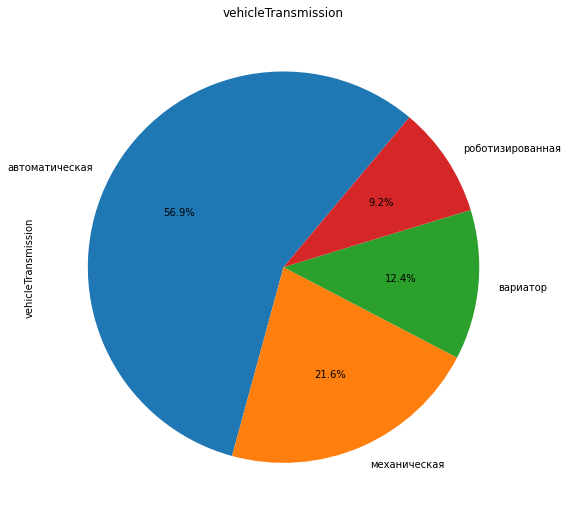

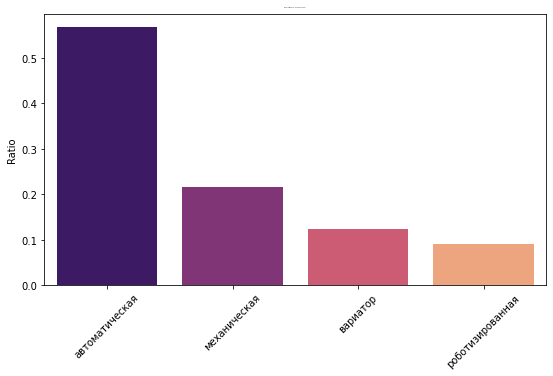

In [109]:
category_ratio(data, 'vehicleTransmission', 4)

In [110]:
# The data has 4 types of transmissions, but 86% of listings have automatic or manual

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


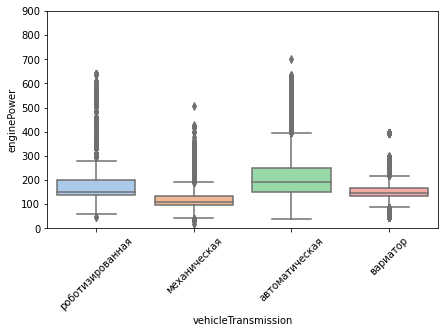

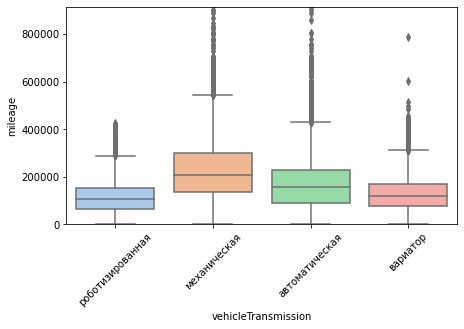

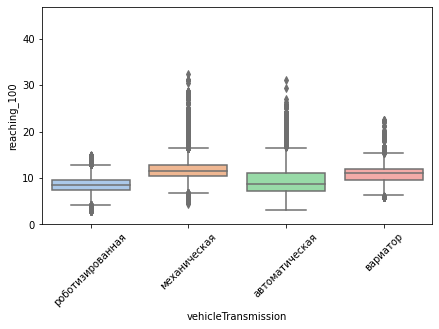

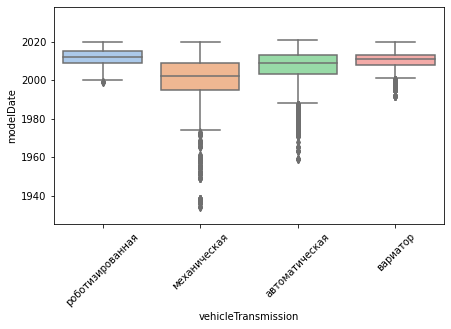

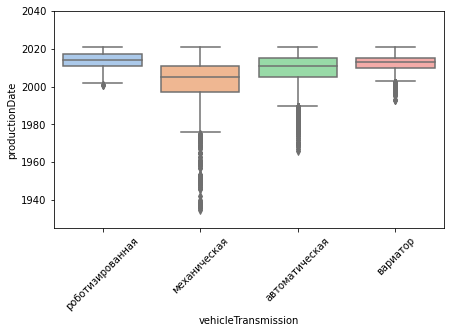

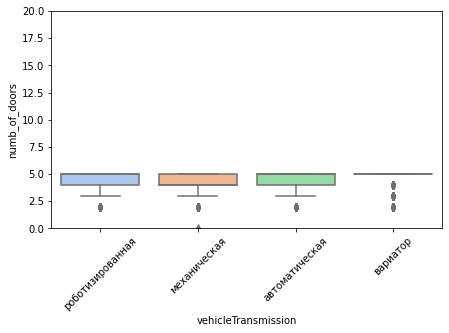

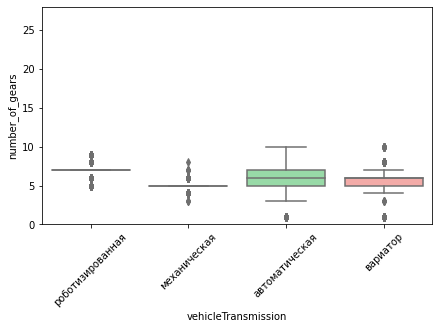

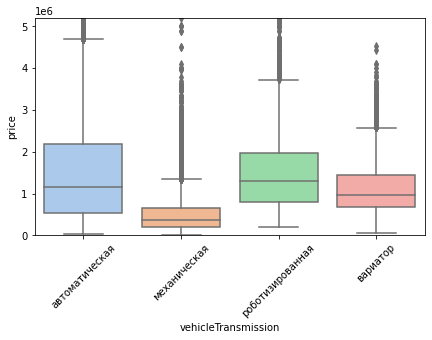

In [111]:
category_over_numeric_features('vehicleTransmission', 4)

In [112]:
# The graph above suggests the 'vehicleTransmission' has significant statistical difference in
# target variable, but I will check it.

In [113]:
get_stat_dif('vehicleTransmission', data, numeric_clmns)

Noticable statisctical significance found for  vehicleTransmission   in relationship to   enginePower
Noticable statisctical significance found for  vehicleTransmission   in relationship to   mileage
Noticable statisctical significance found for  vehicleTransmission   in relationship to   reaching_100
Noticable statisctical significance found for  vehicleTransmission   in relationship to   modelDate
Noticable statisctical significance found for  vehicleTransmission   in relationship to   productionDate
Noticable statisctical significance found for  vehicleTransmission   in relationship to   numb_of_doors
Noticable statisctical significance found for  vehicleTransmission   in relationship to   number_of_gears
Noticable statisctical significance found for  vehicleTransmission   in relationship to   price


In [114]:
# 'vehicleTransmission' has statistically significant differences in 8 numerical features.

# 'owners'

3    60173
1    30895
2    29318
n     2624
Name: owners, dtype: int64

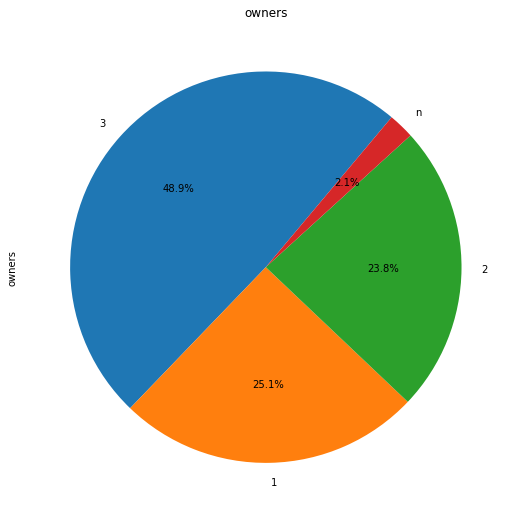

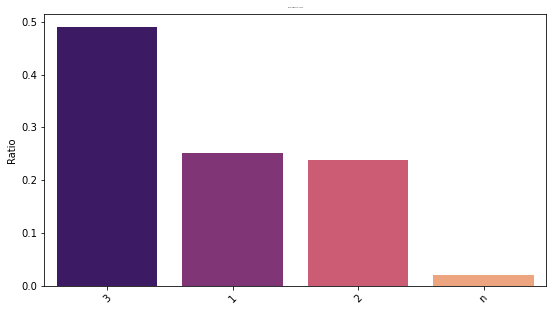

In [115]:
category_ratio(data, 'owners', 4)

In [116]:
# More than 50% of cars had 3 or more than 3 owners.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


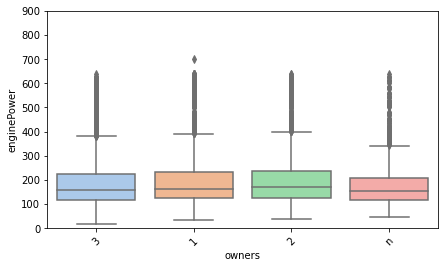

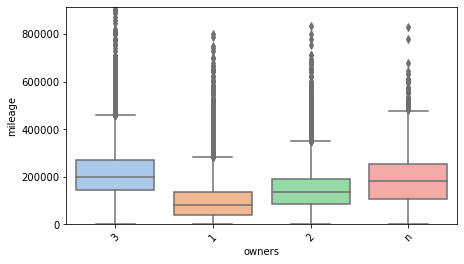

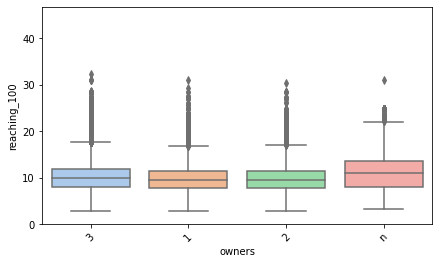

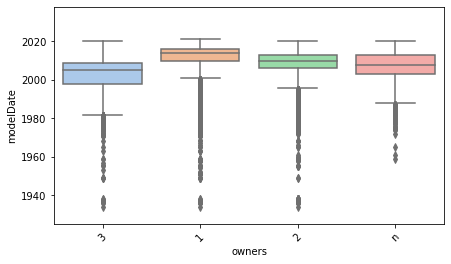

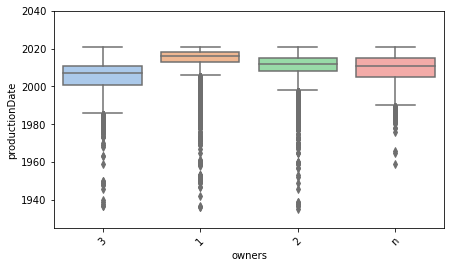

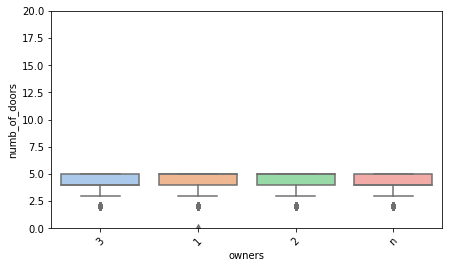

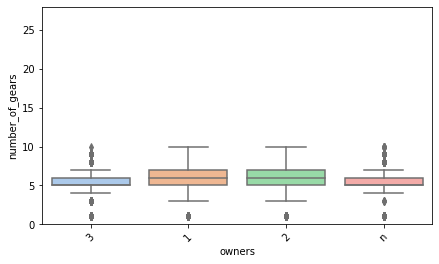

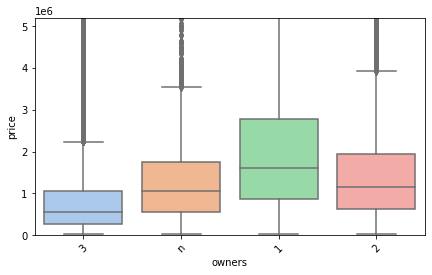

In [117]:
category_over_numeric_features('owners', 4)

In [118]:
# As expected the greater number of owners the older a car and it has more miles.

In [119]:
get_stat_dif('owners', data, numeric_clmns)

Noticable statisctical significance found for  owners   in relationship to   enginePower
Noticable statisctical significance found for  owners   in relationship to   mileage
Noticable statisctical significance found for  owners   in relationship to   reaching_100
Noticable statisctical significance found for  owners   in relationship to   modelDate
Noticable statisctical significance found for  owners   in relationship to   productionDate
Noticable statisctical significance found for  owners   in relationship to   numb_of_doors
Noticable statisctical significance found for  owners   in relationship to   number_of_gears
Noticable statisctical significance found for  owners   in relationship to   price


In [120]:
# 'owners' has statistically significant differences in 8 numerical features.

# 'pts'

Оригинал    103416
Дубликат     19593
Name: pts, dtype: int64

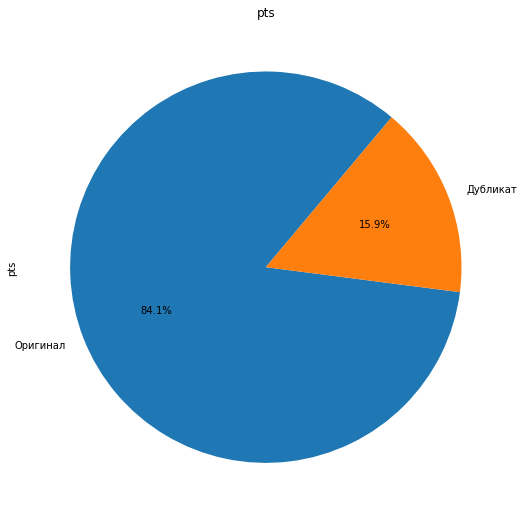

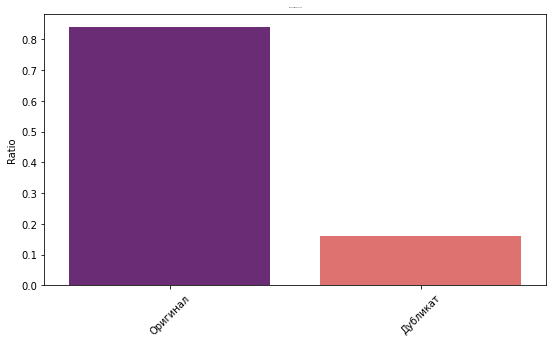

In [121]:
category_ratio(data, 'pts', 2)

In [122]:
# Given data has 85% listings with original title and 15% with duplicate.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


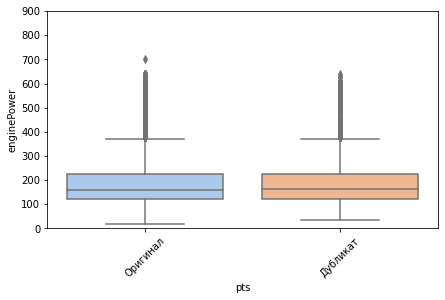

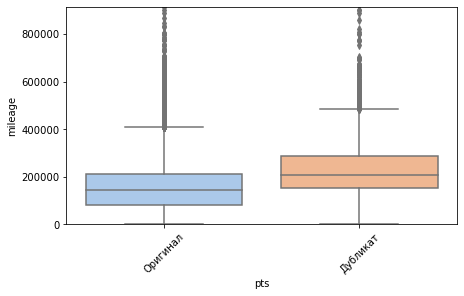

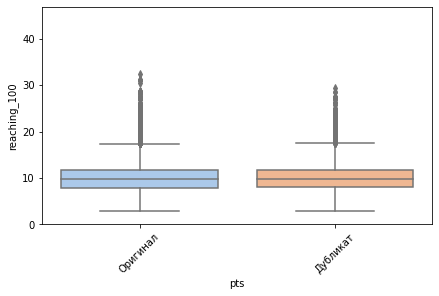

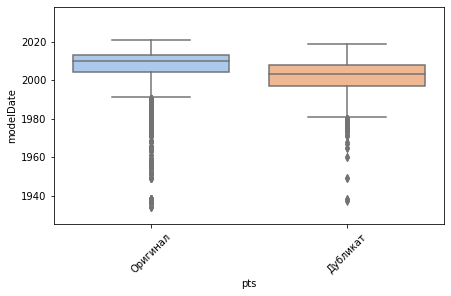

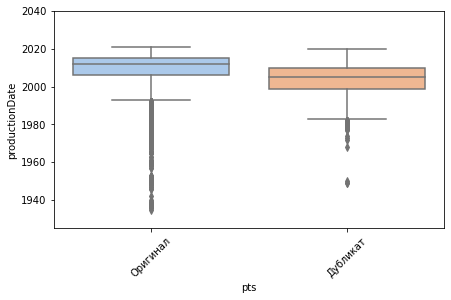

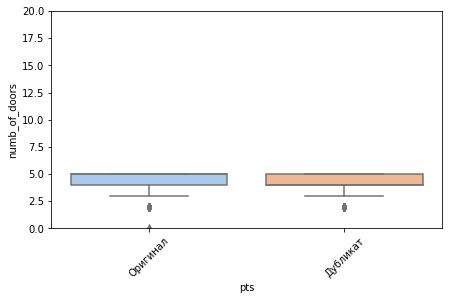

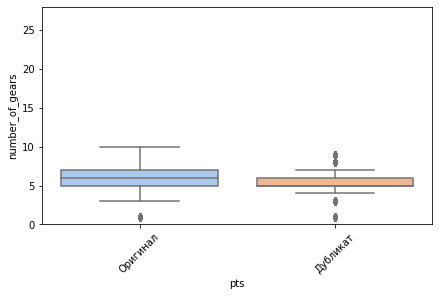

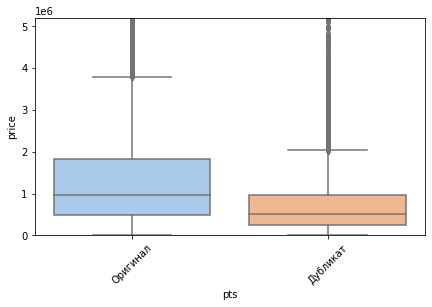

In [123]:
category_over_numeric_features('pts', 2)

In [124]:
# The graph above suggests the 'pts' has significant statistical difference in
# target variable, but I will check it.

In [125]:
get_stat_dif('pts', data, numeric_clmns)

Noticable statisctical significance found for  pts   in relationship to   mileage
Noticable statisctical significance found for  pts   in relationship to   reaching_100
Noticable statisctical significance found for  pts   in relationship to   modelDate
Noticable statisctical significance found for  pts   in relationship to   productionDate
Noticable statisctical significance found for  pts   in relationship to   numb_of_doors
Noticable statisctical significance found for  pts   in relationship to   number_of_gears
Noticable statisctical significance found for  pts   in relationship to   price


In [126]:
# 'pts' has statistically significant differences in 8 numerical features.

# 'privod'

передний    53416
полный      53414
задний      16180
Name: privod, dtype: int64

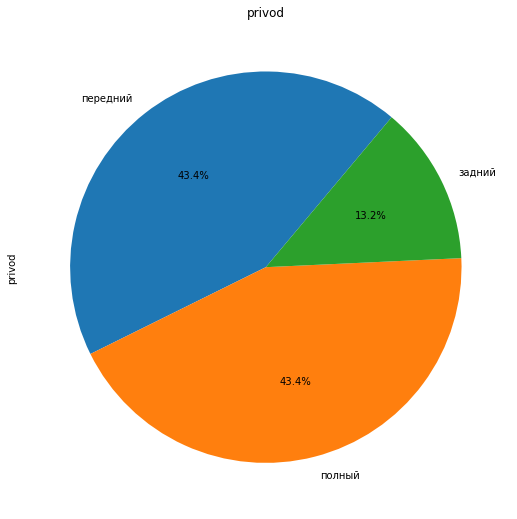

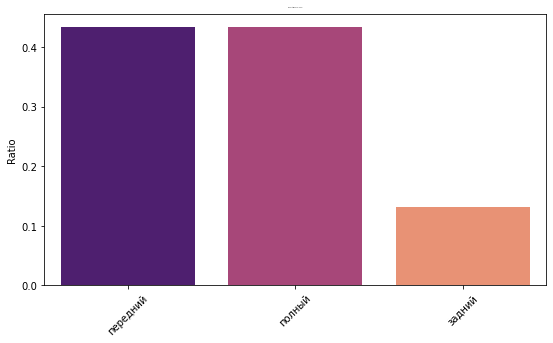

In [127]:
category_ratio(data, 'privod', 3)

In [128]:
#Given data has more than 50% front wheel drive.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


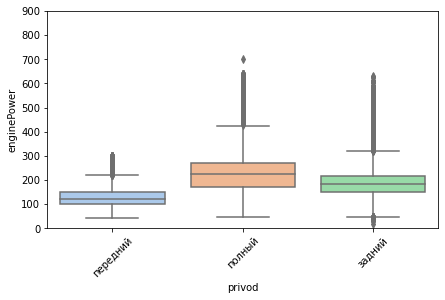

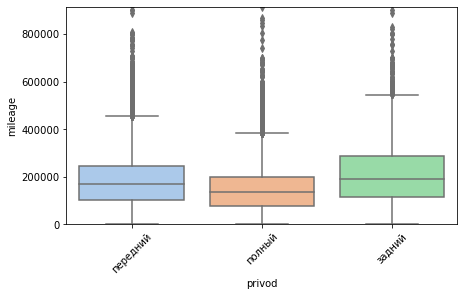

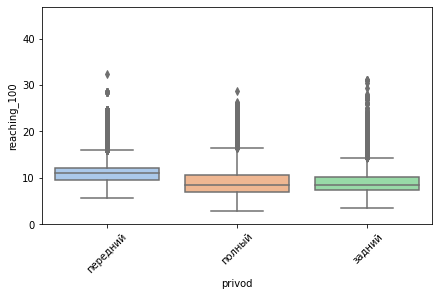

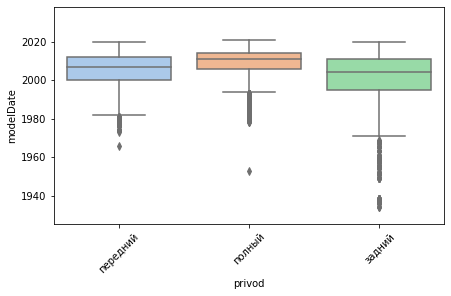

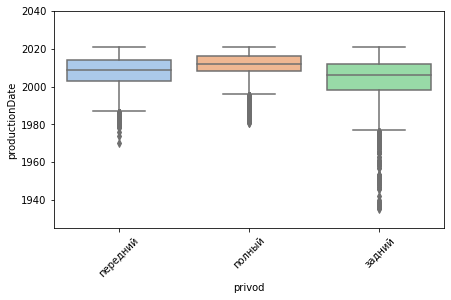

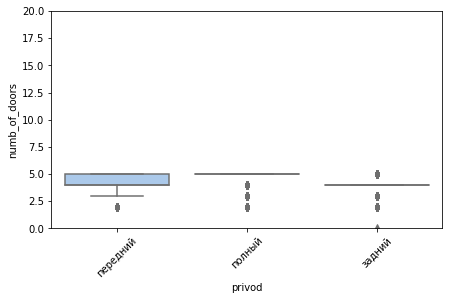

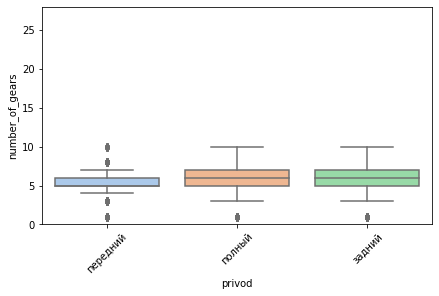

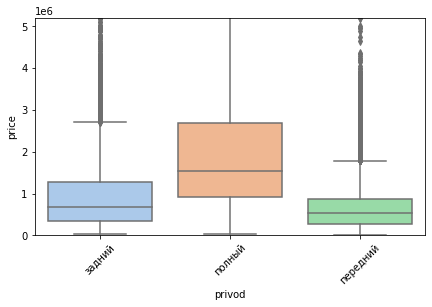

In [129]:
category_over_numeric_features('privod', 3)

In [130]:
# The graph above suggests the 'privdo' has significant statistical difference in
# target variable, but I will check it.

In [131]:
get_stat_dif('privod', data, numeric_clmns)

Noticable statisctical significance found for  privod   in relationship to   enginePower
Noticable statisctical significance found for  privod   in relationship to   mileage
Noticable statisctical significance found for  privod   in relationship to   reaching_100
Noticable statisctical significance found for  privod   in relationship to   modelDate
Noticable statisctical significance found for  privod   in relationship to   productionDate
Noticable statisctical significance found for  privod   in relationship to   numb_of_doors
Noticable statisctical significance found for  privod   in relationship to   number_of_gears
Noticable statisctical significance found for  privod   in relationship to   price


In [132]:
# 'privod' has statistically significant differences in 8 numerical features.

# 'wheel'

Левый     110056
Правый     12954
Name: wheel, dtype: int64

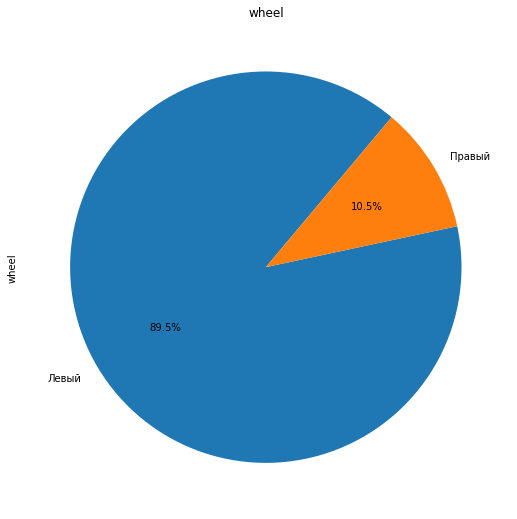

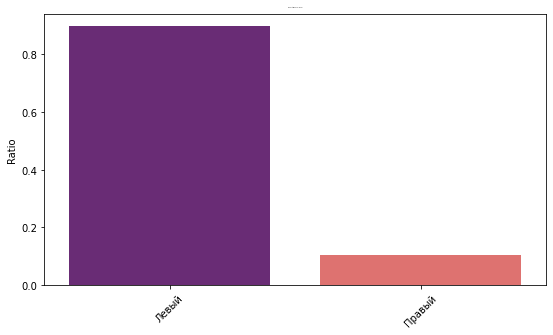

In [133]:
category_ratio(data, 'wheel', 2)

In [134]:
# Interesting the given data has 6% of cars with right side steering wheel.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


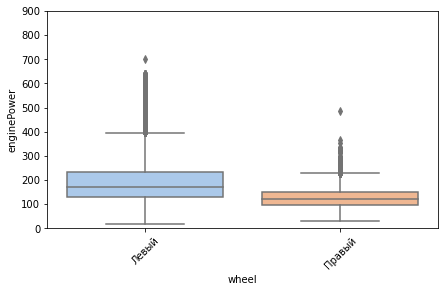

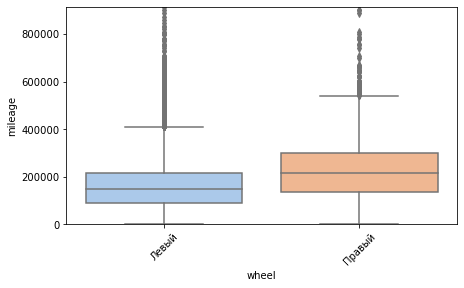

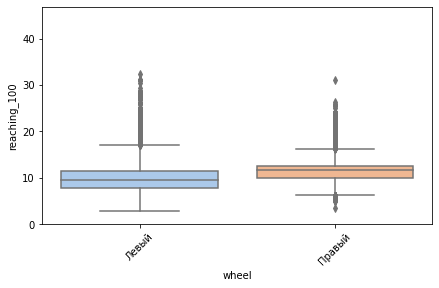

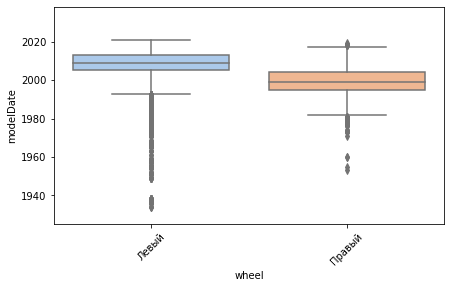

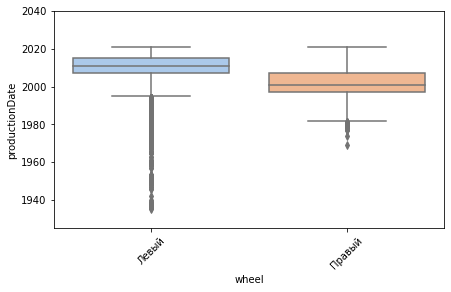

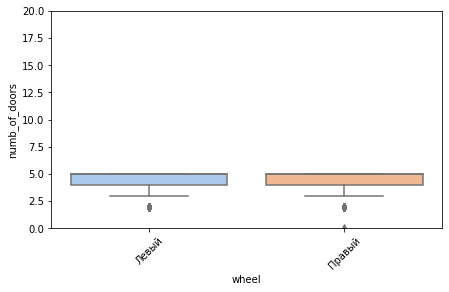

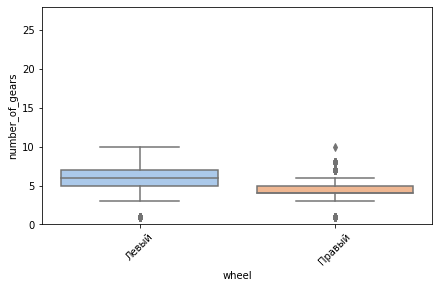

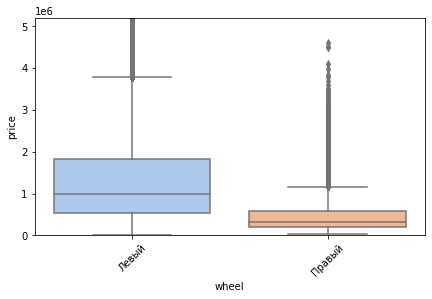

In [135]:
category_over_numeric_features('wheel', 2)

In [136]:
# The right side steering wheel cars are older and have more miles

In [137]:
get_stat_dif('wheel', data, numeric_clmns)

Noticable statisctical significance found for  wheel   in relationship to   enginePower
Noticable statisctical significance found for  wheel   in relationship to   mileage
Noticable statisctical significance found for  wheel   in relationship to   reaching_100
Noticable statisctical significance found for  wheel   in relationship to   modelDate
Noticable statisctical significance found for  wheel   in relationship to   productionDate
Noticable statisctical significance found for  wheel   in relationship to   number_of_gears
Noticable statisctical significance found for  wheel   in relationship to   price


In [138]:
# 'wheel' has statistically significant differences in 8 numerical features.

# 'front_suspension '

независимая, пружинная             113690
независимая, пневмоэлемент           5620
независимая, торсионная              1505
зависимая, пружинная                 1261
независимая, гидропневмоэлемент       766
независимая, рессорная                125
зависимая, рессорная                   43
Name: front_suspension, dtype: int64

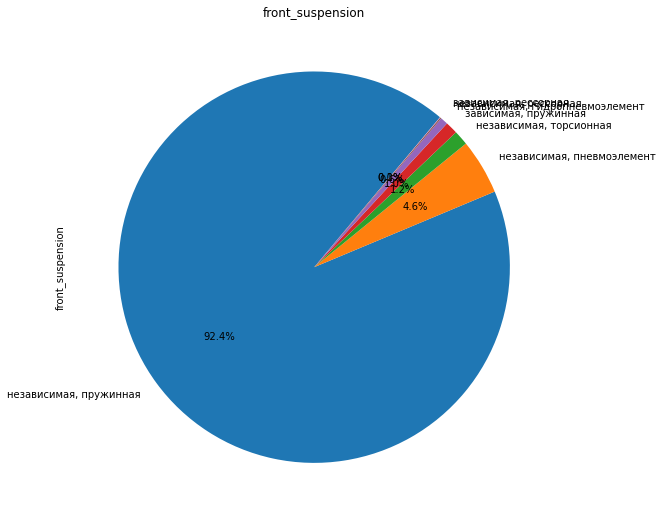

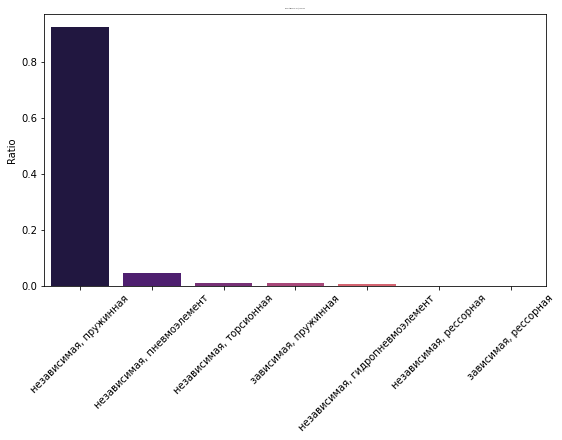

In [139]:
category_ratio(data, 'front_suspension', 7)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


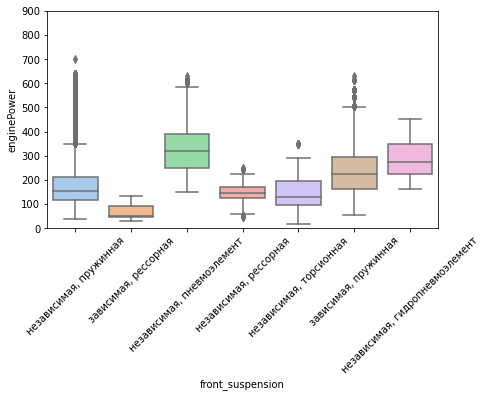

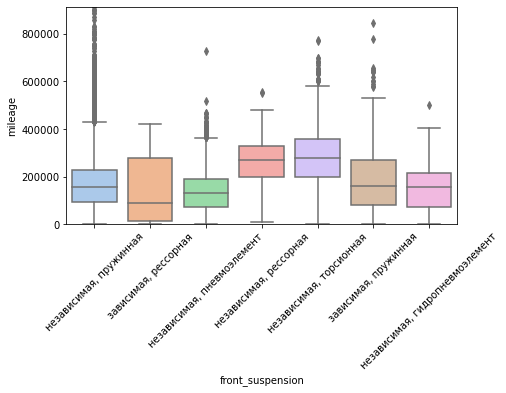

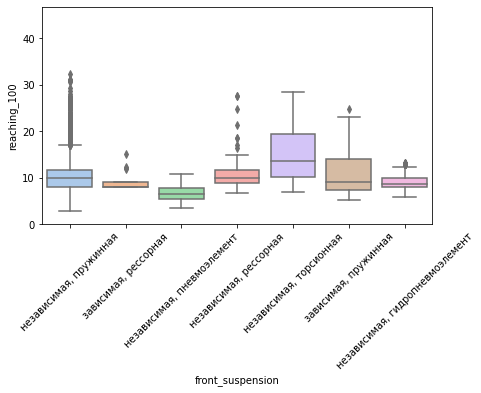

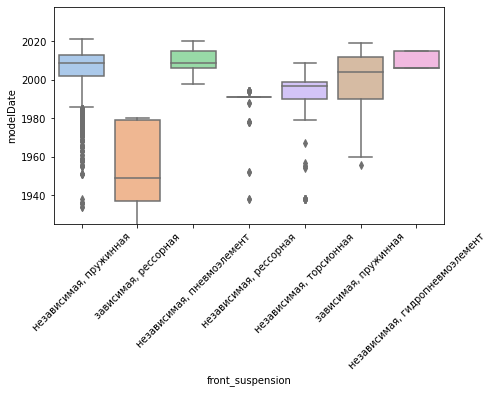

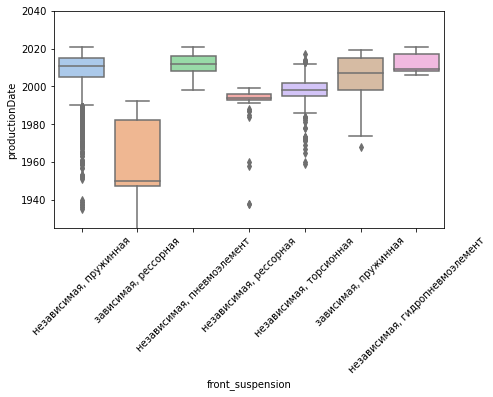

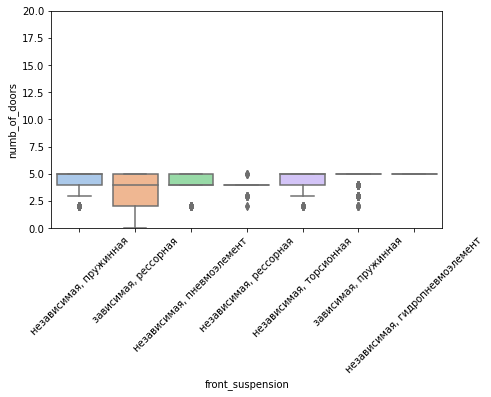

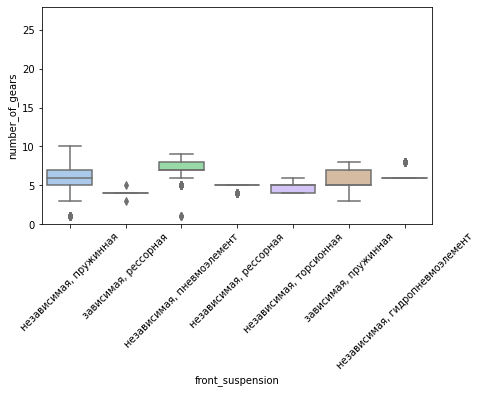

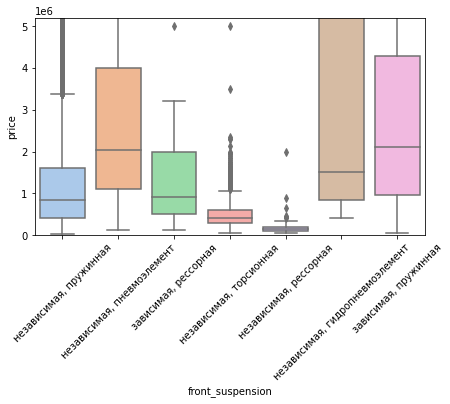

In [140]:
category_over_numeric_features('front_suspension', 7)

In [141]:
# The graph above suggests the 'front_suspension' has significant statistical difference in
# target variable, but I will check it.

In [142]:
get_stat_dif('front_suspension', data, numeric_clmns)

Noticable statisctical significance found for  front_suspension   in relationship to   enginePower
Noticable statisctical significance found for  front_suspension   in relationship to   mileage
Noticable statisctical significance found for  front_suspension   in relationship to   reaching_100
Noticable statisctical significance found for  front_suspension   in relationship to   modelDate
Noticable statisctical significance found for  front_suspension   in relationship to   productionDate
Noticable statisctical significance found for  front_suspension   in relationship to   numb_of_doors
Noticable statisctical significance found for  front_suspension   in relationship to   number_of_gears
Noticable statisctical significance found for  front_suspension   in relationship to   price


In [143]:
# 'front_suspension' has statistically significant differences in 8 numerical features.

# 'back_suspension'

независимая, пружинная             86139
полунезависимая, пружинная         16562
зависимая, пружинная                6993
независимая, пневмоэлемент          6235
полунезависимая, торсионная         3837
зависимая, рессорная                1756
зависимая, пневмоэлемент             702
независимая, гидропневмоэлемент      489
независимая, торсионная              202
независимая, рессорная                95
Name: back_suspension, dtype: int64

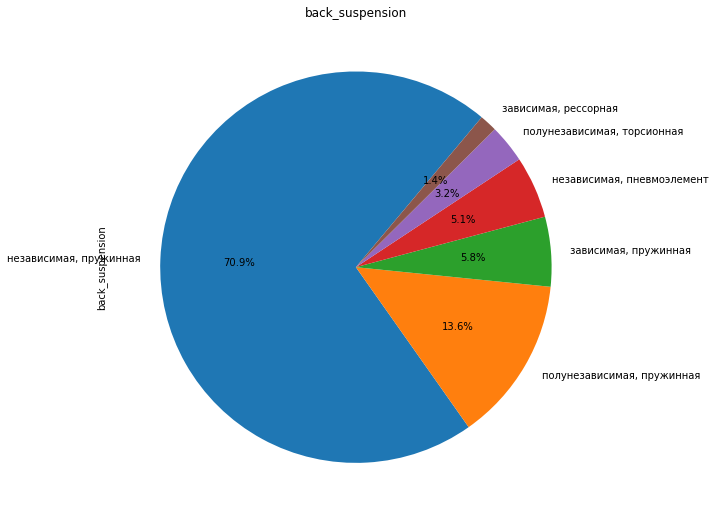

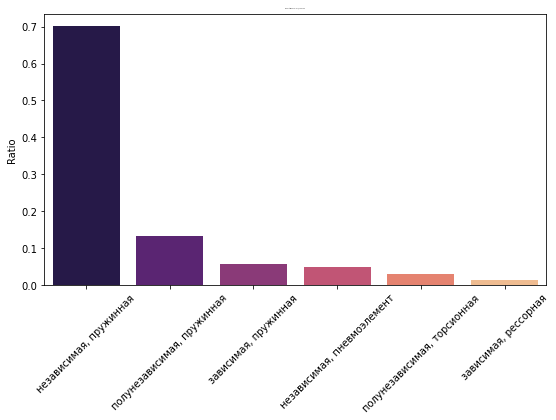

In [144]:
category_ratio(data, 'back_suspension', 6)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


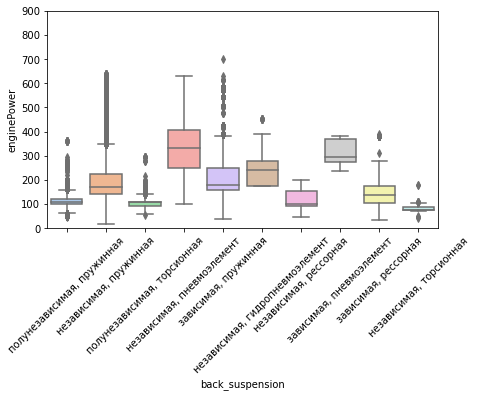

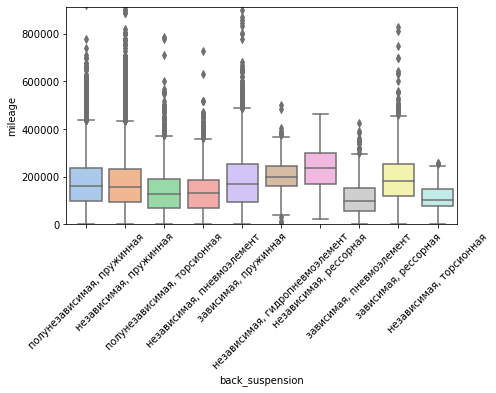

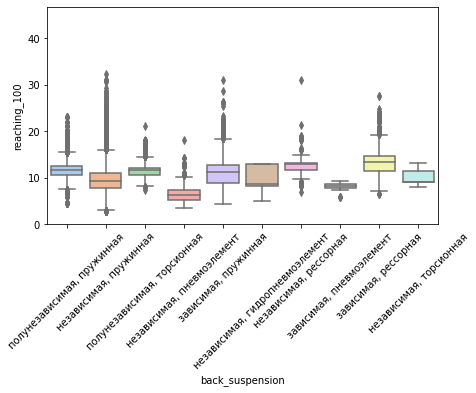

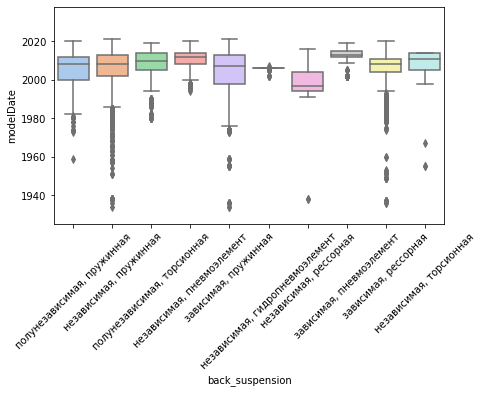

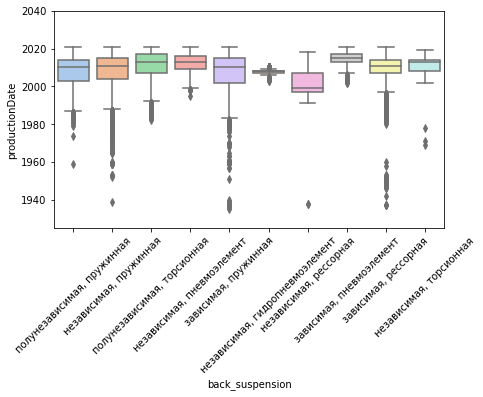

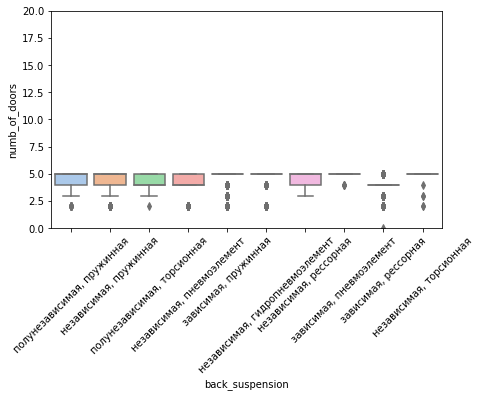

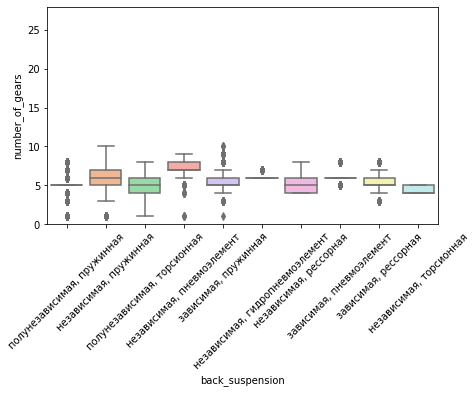

In [145]:
category_over_numeric_features('back_suspension', 10)

In [146]:
# The graph above suggests the 'back_suspension' has significant statistical difference in
# target variable, but I will check it.

In [147]:
get_stat_dif('back_suspension', data, numeric_clmns)

Noticable statisctical significance found for  back_suspension   in relationship to   enginePower
Noticable statisctical significance found for  back_suspension   in relationship to   mileage
Noticable statisctical significance found for  back_suspension   in relationship to   reaching_100
Noticable statisctical significance found for  back_suspension   in relationship to   modelDate
Noticable statisctical significance found for  back_suspension   in relationship to   productionDate
Noticable statisctical significance found for  back_suspension   in relationship to   numb_of_doors
Noticable statisctical significance found for  back_suspension   in relationship to   number_of_gears
Noticable statisctical significance found for  back_suspension   in relationship to   price


In [148]:
# 'back_suspension' has statistically significant differences in 8 numerical features.

# 'front_brakes'

дисковые вентилируемые        112692
дисковые                        9662
барабанные                        85
керамические вентилируемые        34
Name: front_brakes, dtype: int64

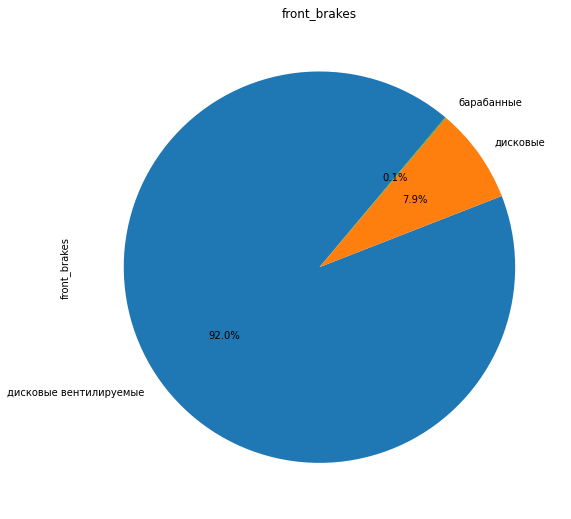

In [149]:
category_ratio(data, 'front_brakes', 3)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


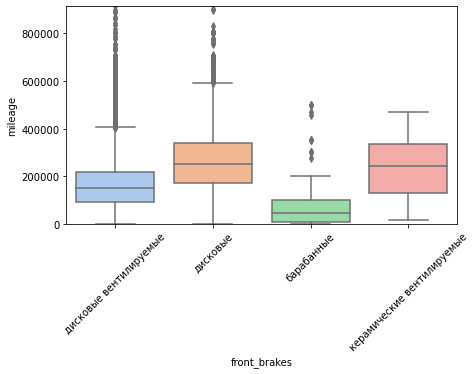

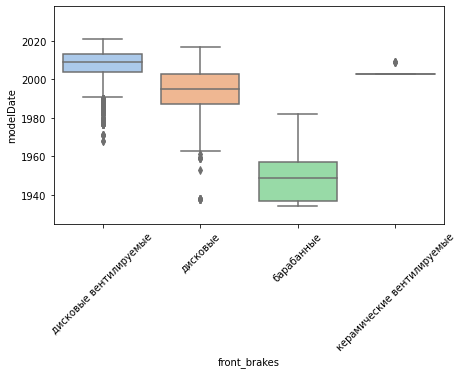

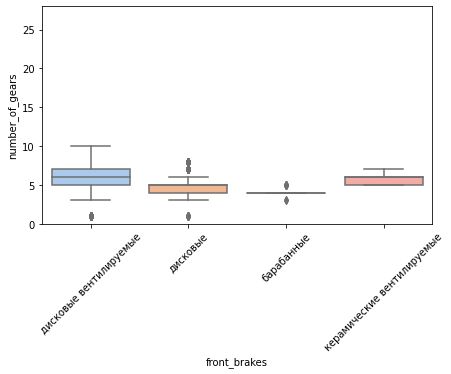

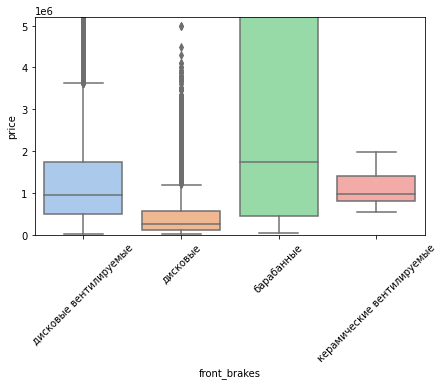

In [150]:
category_over_numeric_features('front_brakes', 4)

In [151]:
# The graph above suggests the 'front_brakes' has significant statistical difference in
# target variable, but I will check it.

In [152]:
get_stat_dif('front_brakes', data, numeric_clmns)

Noticable statisctical significance found for  front_brakes   in relationship to   enginePower
Noticable statisctical significance found for  front_brakes   in relationship to   mileage
Noticable statisctical significance found for  front_brakes   in relationship to   reaching_100
Noticable statisctical significance found for  front_brakes   in relationship to   modelDate
Noticable statisctical significance found for  front_brakes   in relationship to   productionDate
Noticable statisctical significance found for  front_brakes   in relationship to   numb_of_doors
Noticable statisctical significance found for  front_brakes   in relationship to   number_of_gears
Noticable statisctical significance found for  front_brakes   in relationship to   price


In [153]:
# 'front_brakes' has statistically significant differences in 8 numerical features.

# 'back_brakes'

дисковые                      68478
дисковые вентилируемые        32901
барабанные                    19770
керамические вентилируемые        5
Name: back_brakes, dtype: int64

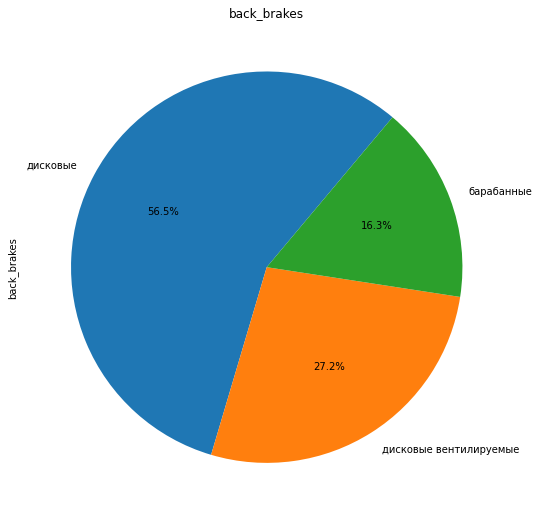

In [154]:
category_ratio(data, 'back_brakes', 3)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


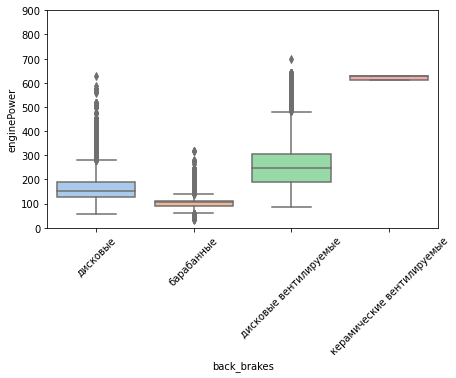

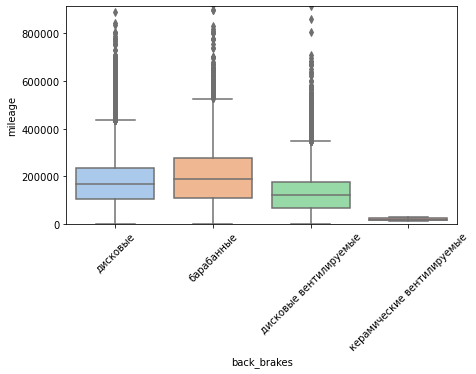

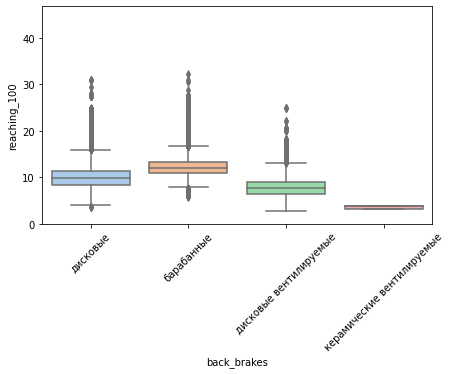

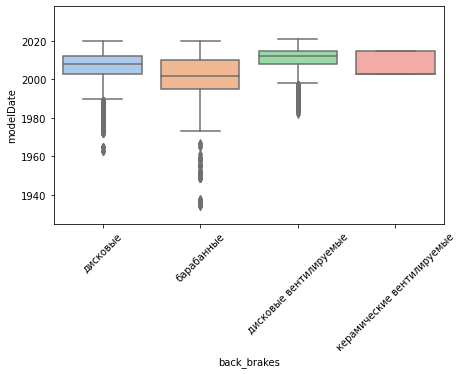

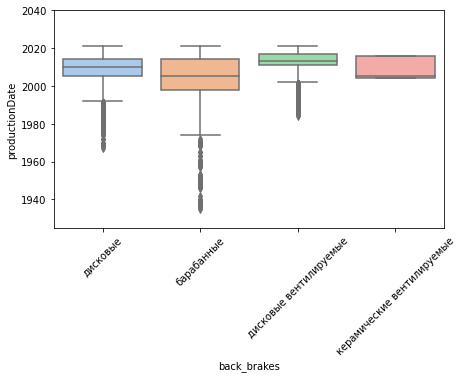

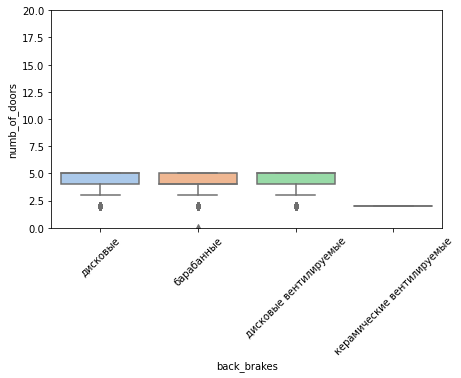

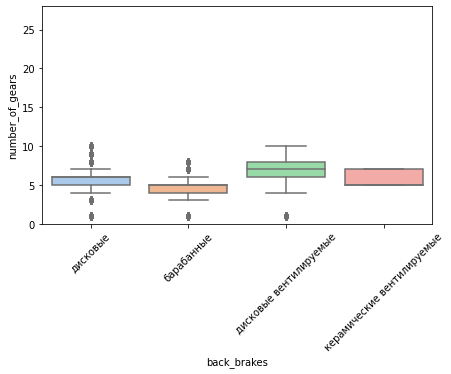

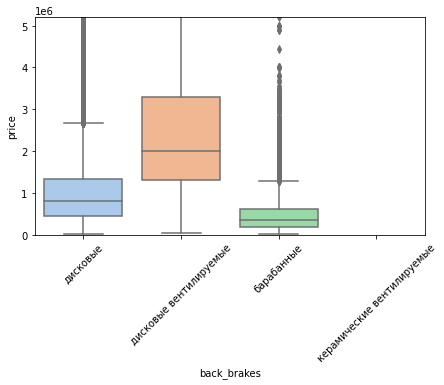

In [155]:
category_over_numeric_features('back_brakes', 4)

In [156]:
# The graph above suggests the 'back_brakes' has significant statistical difference in
# target variable, but I will check it.

In [157]:
get_stat_dif('back_brakes', data, numeric_clmns)

Noticable statisctical significance found for  back_brakes   in relationship to   enginePower
Noticable statisctical significance found for  back_brakes   in relationship to   mileage
Noticable statisctical significance found for  back_brakes   in relationship to   reaching_100
Noticable statisctical significance found for  back_brakes   in relationship to   modelDate
Noticable statisctical significance found for  back_brakes   in relationship to   productionDate
Noticable statisctical significance found for  back_brakes   in relationship to   numb_of_doors
Noticable statisctical significance found for  back_brakes   in relationship to   number_of_gears
Noticable statisctical significance found for  back_brakes   in relationship to   price


In [158]:
# 'back_brakes' has statistically significant differences in 8 numerical features.

 # 'Feature Engineering' <a id="engineering"></a>

In [159]:
# The get_feature_importance() revealed 'enginePower' is most important feature.
# The function below creates new features. These feature are the mean values of 
# 'enginePower' in different categorical features.

def engine_power_ratio(raw):
    category = raw[feature]

    try:
        result = average_table[category]
    except:

        return 1

    return raw['enginePower'] / result


feature_list = ['model',  'engineDisplacement',
                'back_suspension', 'productionDate']

for feature in feature_list:
    average_table = data[data.sample_kaggle ==
                         1].groupby(feature).enginePower.mean()

    data['mean_power_' + feature] = data[[feature, 'enginePower']
                                         ].progress_apply(engine_power_ratio, axis=1)


data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 123010 entries, 0 to 231568
Data columns (total 30 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   bodyType                       123010 non-null  object 
 1   brand                          123010 non-null  object 
 2   color                          123010 non-null  object 
 3   engineDisplacement             123010 non-null  object 
 4   enginePower                    123010 non-null  float64
 5   fuelType                       123010 non-null  object 
 6   mileage                        123010 non-null  float64
 7   modelDate                      123010 non-null  float64
 8   model                          123010 non-null  object 
 9   numb_of_doors                  123010 non-null  float64
 10  productionDate                 123010 non-null  int64  
 11  vehicleTransmission            123010 non-null  object 
 12  owners                       

In [160]:


speed_table = data[data.sample_kaggle == 1].groupby(
    ['number_of_gears', 'engineDisplacement']).reaching_100.mean()

mileage_table = data[data.sample_kaggle == 1].groupby(
    ['productionDate']).mileage.mean()


def mean_ratio(raw, opt):
    if opt == 'speed':
        displ = raw['engineDisplacement']
        gear = raw['number_of_gears']

        try:
            result = speed_table[gear][displ]
        except:
            return raw['reaching_100']

    elif opt == 'mile':
        year = raw['productionDate']

        try:
            result = mileage_table[year]
        except:
            return raw['mileage']

    return result


#The new feature below shows average mileage grouped by manufactured year.

data['mean_mileage_year'] = data[['productionDate', 'mileage']
                                 ].progress_apply(mean_ratio, opt='mile', axis=1)


# The feature below is the mean value 'reaching_100' grouped by 'number_of_gears', 'engineDisplacement'

data['mean_speed_year'] = data[['number_of_gears', 'engineDisplacement',
                                'reaching_100']].progress_apply(mean_ratio, opt='speed', axis=1)



# The feature below is the product of 'enginePower' and 'reaching_100'.

data['mult'] = data['enginePower'] * data['reaching_100']


In [161]:
# 'key_ratio_mean' is the mean value of the ratio 'enginePower' to 'productionDate'
# distributed grouped by 'model' and 'modelDate'.

data['key_ratio'] = data['enginePower'] / (2021 - data['productionDate'] + 2)
key_table = data.groupby(['model', 'modelDate']).key_ratio.mean()
data['key_ratio_mean'] = data[['model', 'modelDate']].progress_apply(
    lambda x: key_table[x['model']][x['modelDate']], axis=1)

In [162]:
#miles_per_owner_table = data.groupby(['brand', 'productionDate', 'owners']).mileage.mean()
#print(len(miles_per_owner_table))
#data['miles_per_owner'] = data[['brand', 'productionDate', 'owners']].progress_apply(lambda x: miles_per_owner_table[x['brand']][x['productionDate']][x['owners']], axis=1)

In [163]:
# The feature below is the deiffernce between 'productionDate' and 'modelDate'

data['model_age'] = data['productionDate'] - data['modelDate']


# The feature below is the ratio of 'enginePower' and 'reaching_100'.

data['power_over_100'] = data['enginePower'] / data['reaching_100']



data['productionDate'] = (2021 - data['productionDate'])

# 'model'

# Label Encoding <a id="encoding"></a>

In [164]:
training = data.copy()

In [165]:
# Defferent experiments with categorical features encoding showed better results with
# cat.codes than pd.get_dummies 


for clmn in ['bodyType', 'brand', 'model', 'color', 'privod', 'owners', 'vehicleTransmission',
             'fuelType','full_name', 'back_suspension', 'front_suspension', 'front_brakes', 
             'back_brakes', 'engineDisplacement', 'wheel', 'pts']:
    training[clmn] = training[clmn].astype('category').cat.codes

In [166]:
# The code below builds table from selected features for model building and then it splits
# data on traing, testing and submission data

training = training[['productionDate','bodyType','brand','model','color','vehicleTransmission', 
            'enginePower','mileage','number_of_gears','privod','fuelType','front_suspension', 
            'back_suspension','front_brakes','back_brakes','reaching_100','modelDate', 
            'engineDisplacement','owners','sample_kaggle','full_name','mean_power_productionDate', 
            'mean_power_model', 'mean_power_engineDisplacement','mean_power_back_suspension', 
            'mean_mileage_year', 'mult', 'mean_speed_year', 'key_ratio_mean',  'model_age', 
            'power_over_100', 'price']] 
                     


X = training.query('sample_kaggle == 1').drop(['sample_kaggle'], axis=1)
Y = X['price']
X = X.drop(['price'], axis=1)

X_sub = training.query('sample_kaggle == 0').drop(['sample_kaggle'], axis=1)
X_sub = X_sub.drop(['price'], axis=1)

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88324 entries, 34686 to 231568
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   productionDate                 88324 non-null  int64  
 1   bodyType                       88324 non-null  int8   
 2   brand                          88324 non-null  int8   
 3   model                          88324 non-null  int16  
 4   color                          88324 non-null  int8   
 5   vehicleTransmission            88324 non-null  int8   
 6   enginePower                    88324 non-null  float64
 7   mileage                        88324 non-null  float64
 8   number_of_gears                88324 non-null  float64
 9   privod                         88324 non-null  int8   
 10  fuelType                       88324 non-null  int8   
 11  front_suspension               88324 non-null  int8   
 12  back_suspension                88324 non-

## Train Split

In [167]:


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=VAL_SIZE, 
                                                    shuffle=True, random_state=RANDOM_SEED)

**All models showed better results with applied log function to target variable.**

# CatBoost <a id="catmodel"></a>

In [168]:
from sklearn.model_selection import cross_val_score
from catboost import Pool, cv

cat_model = CatBoostRegressor(iterations = 10000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          reg_lambda = 7,
                          diffusion_temperature = 4500,
                          metric_period = 2,
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
#cat_model.fit(X_train, np.log(y_train),
         #cat_features=cat_features_ids,
         #eval_set=(X_test, np.log(y_test)),
         #verbose_eval=0,
         #use_best_model=True,
         
         #)

#model.save_model('catboost_single_model_2_baseline.model')

In [169]:


from sklearn.model_selection import GridSearchCV



param_dic = {'iterations': [500],
              'learning_rate': [0.02, 0.1, 0.5],
              'reg_lambda': [1, 3, 5, 7],
              'diffusion_temperature': [11000, 9000, 8000],
              'depth': np.arange(10, 14),
              'thread_count': [4]}



just_grid = GridSearchCV(cat_model, param_dic, n_jobs=-1,
                            cv=5, refit=True,
                            return_train_score=True, verbose=5)



#just_grid.fit(X_train, np.log(y_train))





In [170]:
#predict_test = np.exp(cat_model.predict(X_test))
#predict_submission = np.exp(cat_model.predict(X_sub))
#print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

**CatBoost has a lot of parameters for tuning, I used GridSearchCV and substituted values by hand. 
It helped me to find good values for (reg_lambda, diffusion_temperature, metric_period,
iterations) to get result 13.75%**

In [171]:
#pd.Series(cat_model.get_feature_importance(), index=cat_model.feature_names_).sort_values(ascending=False)

# CatBoost on Folds <a id="catmodelcv"></a>

In [172]:
'''
mape_scores = []


kf = KFold(n_splits=5)
X = np.array(X)
Y = np.array(Y)
for train_index, test_index in kf.split(X):
    
    # use the indexes to extract the folds in the train and validation data
    Xf_train,  Xf_test,  = X[train_index],  X[test_index]
    yf_train, yf_test = Y[train_index], Y[test_index]
    
    
    model.fit(Xf_train, np.log(yf_train),
             #cat_features=cat_features_ids,
             eval_set=(Xf_test, np.log(yf_test)),
             verbose_eval=0,
             use_best_model=True,
             
             )
    
    test_predict = np.exp(model.predict(Xf_test))
    test_score = mape(yf_test, test_predict)
    mape_scores.append(test_score)
    
 '''   

'\nmape_scores = []\n\n\nkf = KFold(n_splits=5)\nX = np.array(X)\nY = np.array(Y)\nfor train_index, test_index in kf.split(X):\n    \n    # use the indexes to extract the folds in the train and validation data\n    Xf_train,  Xf_test,  = X[train_index],  X[test_index]\n    yf_train, yf_test = Y[train_index], Y[test_index]\n    \n    \n    model.fit(Xf_train, np.log(yf_train),\n             #cat_features=cat_features_ids,\n             eval_set=(Xf_test, np.log(yf_test)),\n             verbose_eval=0,\n             use_best_model=True,\n             \n             )\n    \n    test_predict = np.exp(model.predict(Xf_test))\n    test_score = mape(yf_test, test_predict)\n    mape_scores.append(test_score)\n    \n '

**CatBoost with folds only got 14.96% and it took it much more time than just CatBoost.**

# RandomForest <a id="randforest"></a>

In [173]:



random_model = RandomForestRegressor(random_state=42, max_features = 10, 
                                     n_estimators = 400, max_depth = 18,                                   
                                     min_samples_split=7) 

# random_model.fit(X_train, np.log(y_train))



In [174]:


param_dic = {'max_features': [3,5,7,11],
              'n_estimators': [200, 400, 600],
              'max_depth': [5, 15, 20, 35],
              'min_samples_split': [2, 5, 8]
              
              }



rand_grid = GridSearchCV(random_model, param_dic, n_jobs=-1,
                            cv=5, refit=True,
                            return_train_score=True, verbose=5)



# rand_grid.fit(X_train, np.log(y_train))

# print(rand_grid.best_params_)



In [175]:
#predict_test = np.exp(random_model.predict(X_test))
#predict_submission = np.exp(random_model.predict(X_sub))
#print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

**It took a lot of time to tune RandomForest and the result is 14.17%**

# GradientBoosting <a id="grad"></a>

In [176]:
grad_model = GradientBoostingRegressor(random_state=42, n_estimators = 1200, 
                                       loss = 'huber', learning_rate = 0.3, 
                                       max_depth = 3, alpha = 0.8, validation_fraction = 0.1)

#grad_model.fit(X_train, np.log(y_train))

In [177]:
param_dic = {
              'n_estimators': [500, 800, 1000],
              'max_depth': [3, 5, 15],
              'alpha': [0.2, 0.5]
              
              }



grad_grid = GridSearchCV(grad_model, param_dic, n_jobs=-1, 
                         refit=True, return_train_score=True, verbose=5)



#grad_grid.fit(X_train, np.log(y_train))

#print(grad_grid.best_params_)

In [178]:
#predict_test = np.exp(grad_model.predict(X_test))
#print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

**It took a lot of time to tune GradientBoosting and the result is 14.2%**

# XGBoost <a id="xgboost"></a>

In [179]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,
                          learning_rate=0.1, max_depth=5,subsample=1, random_state=0,
                          n_estimators=1700, min_child_weight= 1, gamma = 0.0, silent=1)
#xgb_model.fit(X_train, np.log(y_train))

In [180]:
param_dic = {
    'max_depth': [4, 5, 7],
    'min_child_weight': [1, 3],
    'learning_rate': [0.05, 0.1, 0.3]
}

xgb_grid = GridSearchCV(xgb_model, param_dic, n_jobs=-1,
                        refit=True, return_train_score=True, verbose=5)

#xgb_grid.fit(X_train, np.log(y_train))

#print(xgb_grid.best_params_)

**XGBoost model is faster than some models before, the result is 14.12%**

# LGBMRegressor <a id="lightgb"></a>

In [181]:
lgbm_model = LGBMRegressor(objective = 'regression', num_iterations = 1200, 
                           n_estimators = 1000, num_leaves = 29, max_depth = -1,  
                           min_child_samples = 20,  colsample_bytree = 0.17)

#lgbm_model.fit(X_train, np.log(y_train))

In [182]:
param_dic = {
 'min_child_weight':[0.001, 0.005, 0.01],
 'num_leaves':[15, 31, 60, 100],
 'colsample_bytree': [0.05, 0.1, 0.2, 0.5, 1],
 'min_child_samples': [10, 20, 30]

}

light_grid = GridSearchCV(lgbm_model, param_dic, n_jobs=-1,
                        refit=True, return_train_score=True,  verbose=5)


#light_grid.fit(X_train, np.log(y_train))
#print(light_grid.best_params_)

In [183]:
#predict_test = np.exp(lgbm_model.predict(X_test))
#predict_submission = np.exp(lgbm_model.predict(X_sub))
#print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

**LGBMRegressor is the fastest and easy to tune algorithm in this notebook. 
The result is good too 13.99%**

# Bagging <a id="bagging"></a>

In [184]:


bagging_model = BaggingRegressor(lgbm_model,  n_estimators = 25, max_samples = 0.6, 
                                 random_state=42).fit(X_train, np.log(y_train))

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n

In [185]:
'''
from sklearn.model_selection import ParameterGrid
new_val = 100
grid = ParameterGrid({"max_samples": [0.7, 1.0],
                          "n_estimators": [15,25],
                          "bootstrap": [True, False],
                          "bootstrap_features": [True, False]})

for base_estimator in [None, lgbm_model]:
    for params in grid:
        clm = BaggingRegressor(base_estimator=base_estimator,
                                  random_state=42,
                                  **params).fit(X_train, np.log(y_train)).predict(X_test)
        predict_test = np.exp(bagging_model.predict(X_test))
        val = mape(y_test, predict_test)
        if val < new_val:
            new_val = val
            
            best_params = params
            
'''

'\nfrom sklearn.model_selection import ParameterGrid\nnew_val = 100\ngrid = ParameterGrid({"max_samples": [0.7, 1.0],\n                          "n_estimators": [15,25],\n                          "bootstrap": [True, False],\n                          "bootstrap_features": [True, False]})\n\nfor base_estimator in [None, lgbm_model]:\n    for params in grid:\n        clm = BaggingRegressor(base_estimator=base_estimator,\n                                  random_state=42,\n                                  **params).fit(X_train, np.log(y_train)).predict(X_test)\n        predict_test = np.exp(bagging_model.predict(X_test))\n        val = mape(y_test, predict_test)\n        if val < new_val:\n            new_val = val\n            \n            best_params = params\n            \n'

In [186]:
predict_test = np.exp(bagging_model.predict(X_test))
predict_submission = np.exp(bagging_model.predict(X_sub))
print(f"Model Accuracy: MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Model Accuracy: MAPE: 13.83%


[AdaBoost](#adaboost)

**I experimented with following algorithms (XGBoost, GradientBoosting, RandomForest, CatBoost) to
build Bagging model. LGBMRegressor implemented in Bagging gave the best submission result and second best
result on test data. I submitted this model.**

# AdaBoost <a id="adaboost"></a>

In [187]:
ada_model = AdaBoostRegressor(base_estimator = bagging_model, random_state=42, 
                              n_estimators=3,  loss = 'exponential')

#ada_model.fit(X_train, np.log(y_train))

In [188]:
#predict_test = np.exp(ada_model.predict(X_test))
#print(f"Model Accuracy: MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

**AdaBoost model took a lot of time to tune and to train. I chose Bagging model in AdaBoost. The
result is 14.03%**

# Stacking

In [189]:



models = [('lg', lgbm_model), ('xg', xgb_model)]

stacking_regr = StackingRegressor(estimators = models, 
                                  final_estimator = cat_model, 
                                  cv = 3)

#stacking_regr.fit(X_train, np.log(y_train))

In [190]:
#predict_test = np.exp(stacking_regr.predict(X_test))

#predict_submission = np.exp(model.predict(X_sub))

#print(f"Model Accuracy: MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

**I experimented with many models to build Stacking model. It takes a lot of time
to train it. I selected XGBoost and LGBMR models to build Stacking Model and the
result is 14.07%**

# Voting Algorithm <a id="voting"></a>

In [191]:
voting_model = VotingRegressor(estimators=[('cat', xgb_model), ('grad', grad_model), 
                                           ('vote', bagging_model)], weights=[20, 15, 140])

#voting_model.fit(X_train, np.log(y_train))

In [192]:
param_dic = {
 'weights':[[10, 5, 5], [0, 5, 10], [2,5,5]]
 

}

voting_grid = GridSearchCV(voting_model, param_dic, n_jobs=-1,
                        refit=True, return_train_score=True,  verbose=5)


#voting_grid.fit(X_train, np.log(y_train))
#print(voting_grid.best_params_)

In [193]:
#predict_test = np.exp(voting_model.predict(X_test))

#predict_submission = np.exp(model.predict(X_sub))

#print(f"Model Accuracy: MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

**Voting model took some time to select algorithm and to find optimal weights for selected 
algorithms in it. The result is 13.78%. I got second best result from this notebook models 
on submission and second best result on testing data.**

# Submission

**Bagging Model build on LGBMRegressor was selected for submission, because it gives
best results on submission data. This model returned second best results on testing 
data. CatBoost model gives best result on test data.**

**The submission data was collected in 2020 and I collected my data for training in 2021. During that time world
experienced huge covid pandemic. This pandemic had big influence on markets, car markets... So to improve my
result I multiplied my submission prediction by coefficient. The value of coefficient is 0.87.**

In [194]:
sample_submission['price'] = predict_submission * 0.87
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head(10)

sell_id         price
0  1100575026  6.604120e+05
1  1100549428  9.253676e+05
2  1100658222  9.325023e+05
3  1100937408  7.697668e+05
4  1101037972  7.134226e+05
5  1100912634  7.513172e+05
6  1101228730  6.492407e+05
7  1100165896  4.275885e+05
8  1100768262  1.858549e+06
9  1101218501  7.895266e+05

# IDEAS